In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : ['t1t2'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(792888, 828)
(792888, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/80 [..............................] - ETA: 1:41 - loss: 0.0514 - STD: 1.1287e-04 - MAE: 0.2098

 4/80 [>.............................] - ETA: 2s - loss: 0.0237 - STD: 2.6688e-04 - MAE: 0.1204  

 5/80 [>.............................] - ETA: 2s - loss: 0.0233 - STD: 2.5074e-04 - MAE: 0.1196

 6/80 [=>............................] - ETA: 2s - loss: 0.0232 - STD: 2.3463e-04 - MAE: 0.1197

 7/80 [=>............................] - ETA: 3s - loss: 0.0232 - STD: 2.2070e-04 - MAE: 0.1196

 8/80 [==>...........................] - ETA: 3s - loss: 0.0229 - STD: 2.0965e-04 - MAE: 0.1188

 9/80 [==>...........................] - ETA: 3s - loss: 0.0224 - STD: 2.0127e-04 - MAE: 0.1171

10/80 [==>...........................] - ETA: 3s - loss: 0.0218 - STD: 1.9552e-04 - MAE: 0.1146

11/80 [===>..........................] - ETA: 3s - loss: 0.0210 - STD: 1.9193e-04 - MAE: 0.1117

12/80 [===>..........................] - ETA: 3s - loss: 0.0201 - STD: 1.9031e-04 - MAE: 0.1087

13/80 [===>..........................] - ETA: 3s - loss: 0.0193 - STD: 1.9030e-04 - MAE: 0.1060

14/80 [====>.........................] - ETA: 3s - loss: 0.0186 - STD: 1.9133e-04 - MAE: 0.1040

15/80 [====>.........................] - ETA: 3s - loss: 0.0180 - STD: 1.9322e-04 - MAE: 0.1026

16/80 [=====>........................] - ETA: 3s - loss: 0.0176 - STD: 1.9554e-04 - MAE: 0.1019

17/80 [=====>........................] - ETA: 3s - loss: 0.0173 - STD: 1.9813e-04 - MAE: 0.1016

18/80 [=====>........................] - ETA: 3s - loss: 0.0171 - STD: 2.0112e-04 - MAE: 0.1014

19/80 [======>.......................] - ETA: 3s - loss: 0.0168 - STD: 2.0399e-04 - MAE: 0.1009

20/80 [======>.......................] - ETA: 3s - loss: 0.0165 - STD: 2.0669e-04 - MAE: 0.1002

21/80 [======>.......................] - ETA: 3s - loss: 0.0162 - STD: 2.0925e-04 - MAE: 0.0992

22/80 [=======>......................] - ETA: 3s - loss: 0.0159 - STD: 2.1162e-04 - MAE: 0.0982

23/80 [=======>......................] - ETA: 3s - loss: 0.0156 - STD: 2.1351e-04 - MAE: 0.0971

24/80 [========>.....................] - ETA: 3s - loss: 0.0153 - STD: 2.1522e-04 - MAE: 0.0961

25/80 [========>.....................] - ETA: 3s - loss: 0.0151 - STD: 2.1670e-04 - MAE: 0.0953

26/80 [========>.....................] - ETA: 2s - loss: 0.0149 - STD: 2.1813e-04 - MAE: 0.0944

27/80 [=========>....................] - ETA: 2s - loss: 0.0147 - STD: 2.1949e-04 - MAE: 0.0937

28/80 [=========>....................] - ETA: 2s - loss: 0.0146 - STD: 2.2113e-04 - MAE: 0.0931

29/80 [=========>....................] - ETA: 2s - loss: 0.0144 - STD: 2.2294e-04 - MAE: 0.0924

30/80 [==========>...................] - ETA: 2s - loss: 0.0143 - STD: 2.2511e-04 - MAE: 0.0918

31/80 [==========>...................] - ETA: 3s - loss: 0.0142 - STD: 2.2743e-04 - MAE: 0.0912

35/80 [============>.................] - ETA: 2s - loss: 0.0137 - STD: 2.4066e-04 - MAE: 0.0894

36/80 [============>.................] - ETA: 2s - loss: 0.0135 - STD: 2.4465e-04 - MAE: 0.0891

37/80 [============>.................] - ETA: 2s - loss: 0.0134 - STD: 2.4884e-04 - MAE: 0.0888

38/80 [=============>................] - ETA: 2s - loss: 0.0133 - STD: 2.5312e-04 - MAE: 0.0886

39/80 [=============>................] - ETA: 2s - loss: 0.0132 - STD: 2.5741e-04 - MAE: 0.0884

40/80 [==============>...............] - ETA: 2s - loss: 0.0131 - STD: 2.6173e-04 - MAE: 0.0882

41/80 [==============>...............] - ETA: 2s - loss: 0.0130 - STD: 2.6588e-04 - MAE: 0.0879

42/80 [==============>...............] - ETA: 2s - loss: 0.0130 - STD: 2.7001e-04 - MAE: 0.0876

43/80 [===============>..............] - ETA: 2s - loss: 0.0129 - STD: 2.7417e-04 - MAE: 0.0874

44/80 [===============>..............] - ETA: 2s - loss: 0.0128 - STD: 2.7830e-04 - MAE: 0.0871

45/80 [===============>..............] - ETA: 2s - loss: 0.0127 - STD: 2.8252e-04 - MAE: 0.0868

46/80 [================>.............] - ETA: 2s - loss: 0.0126 - STD: 2.8665e-04 - MAE: 0.0865

47/80 [================>.............] - ETA: 2s - loss: 0.0125 - STD: 2.9094e-04 - MAE: 0.0862

48/80 [=================>............] - ETA: 2s - loss: 0.0125 - STD: 2.9534e-04 - MAE: 0.0859

49/80 [=================>............] - ETA: 1s - loss: 0.0124 - STD: 2.9995e-04 - MAE: 0.0857

50/80 [=================>............] - ETA: 1s - loss: 0.0123 - STD: 3.0463e-04 - MAE: 0.0855

51/80 [==================>...........] - ETA: 1s - loss: 0.0123 - STD: 3.0963e-04 - MAE: 0.0852

52/80 [==================>...........] - ETA: 1s - loss: 0.0122 - STD: 3.1488e-04 - MAE: 0.0850

53/80 [==================>...........] - ETA: 1s - loss: 0.0122 - STD: 3.2049e-04 - MAE: 0.0849

54/80 [===================>..........] - ETA: 1s - loss: 0.0121 - STD: 3.2630e-04 - MAE: 0.0847

55/80 [===================>..........] - ETA: 1s - loss: 0.0121 - STD: 3.3234e-04 - MAE: 0.0845

56/80 [====================>.........] - ETA: 1s - loss: 0.0120 - STD: 3.3883e-04 - MAE: 0.0844

57/80 [====================>.........] - ETA: 1s - loss: 0.0120 - STD: 3.4543e-04 - MAE: 0.0843

58/80 [====================>.........] - ETA: 1s - loss: 0.0119 - STD: 3.5233e-04 - MAE: 0.0841

59/80 [=====================>........] - ETA: 1s - loss: 0.0119 - STD: 3.5932e-04 - MAE: 0.0840

60/80 [=====================>........] - ETA: 1s - loss: 0.0118 - STD: 3.6631e-04 - MAE: 0.0839

61/80 [=====================>........] - ETA: 1s - loss: 0.0118 - STD: 3.7357e-04 - MAE: 0.0837

62/80 [======================>.......] - ETA: 1s - loss: 0.0117 - STD: 3.8088e-04 - MAE: 0.0836

63/80 [======================>.......] - ETA: 1s - loss: 0.0117 - STD: 3.8845e-04 - MAE: 0.0834

64/80 [=======================>......] - ETA: 1s - loss: 0.0116 - STD: 3.9625e-04 - MAE: 0.0833

65/80 [=======================>......] - ETA: 0s - loss: 0.0116 - STD: 4.0413e-04 - MAE: 0.0832

66/80 [=======================>......] - ETA: 0s - loss: 0.0116 - STD: 4.1245e-04 - MAE: 0.0830

67/80 [========================>.....] - ETA: 0s - loss: 0.0115 - STD: 4.2097e-04 - MAE: 0.0829

68/80 [========================>.....] - ETA: 0s - loss: 0.0115 - STD: 4.3000e-04 - MAE: 0.0828

69/80 [========================>.....] - ETA: 0s - loss: 0.0115 - STD: 4.3930e-04 - MAE: 0.0826

70/80 [=========================>....] - ETA: 0s - loss: 0.0114 - STD: 4.4892e-04 - MAE: 0.0825

71/80 [=========================>....] - ETA: 0s - loss: 0.0114 - STD: 4.5921e-04 - MAE: 0.0824

72/80 [==========================>...] - ETA: 0s - loss: 0.0114 - STD: 4.6977e-04 - MAE: 0.0823

73/80 [==========================>...] - ETA: 0s - loss: 0.0113 - STD: 4.8074e-04 - MAE: 0.0822

74/80 [==========================>...] - ETA: 0s - loss: 0.0113 - STD: 4.9239e-04 - MAE: 0.0821

75/80 [===========================>..] - ETA: 0s - loss: 0.0113 - STD: 5.0429e-04 - MAE: 0.0821

76/80 [===========================>..] - ETA: 0s - loss: 0.0113 - STD: 5.1696e-04 - MAE: 0.0820

77/80 [===========================>..] - ETA: 0s - loss: 0.0112 - STD: 5.2999e-04 - MAE: 0.0819

78/80 [============================>.] - ETA: 0s - loss: 0.0112 - STD: 5.4354e-04 - MAE: 0.0818

79/80 [============================>.] - ETA: 0s - loss: 0.0112 - STD: 5.5739e-04 - MAE: 0.0817

80/80 [==============================] - ETA: 0s - loss: 0.0111 - STD: 5.7169e-04 - MAE: 0.0816

80/80 [==============================] - 7s 71ms/step - loss: 0.0111 - STD: 5.7169e-04 - MAE: 0.0816 - val_loss: 0.0085 - val_STD: 0.0012 - val_MAE: 0.0709


Epoch 2/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0092 - STD: 0.0018 - MAE: 0.0755

 2/80 [..............................] - ETA: 4s - loss: 0.0091 - STD: 0.0018 - MAE: 0.0750

 3/80 [>.............................] - ETA: 4s - loss: 0.0091 - STD: 0.0019 - MAE: 0.0751

 4/80 [>.............................] - ETA: 4s - loss: 0.0091 - STD: 0.0019 - MAE: 0.0750

 5/80 [>.............................] - ETA: 4s - loss: 0.0091 - STD: 0.0020 - MAE: 0.0749

 6/80 [=>............................] - ETA: 4s - loss: 0.0091 - STD: 0.0020 - MAE: 0.0747

 7/80 [=>............................] - ETA: 4s - loss: 0.0091 - STD: 0.0021 - MAE: 0.0749

 8/80 [==>...........................] - ETA: 4s - loss: 0.0090 - STD: 0.0021 - MAE: 0.0748

 9/80 [==>...........................] - ETA: 4s - loss: 0.0091 - STD: 0.0022 - MAE: 0.0748

10/80 [==>...........................] - ETA: 4s - loss: 0.0091 - STD: 0.0022 - MAE: 0.0749

11/80 [===>..........................] - ETA: 4s - loss: 0.0091 - STD: 0.0023 - MAE: 0.0749

12/80 [===>..........................] - ETA: 4s - loss: 0.0091 - STD: 0.0024 - MAE: 0.0749

13/80 [===>..........................] - ETA: 3s - loss: 0.0091 - STD: 0.0024 - MAE: 0.0749

14/80 [====>.........................] - ETA: 3s - loss: 0.0090 - STD: 0.0025 - MAE: 0.0748

15/80 [====>.........................] - ETA: 3s - loss: 0.0090 - STD: 0.0026 - MAE: 0.0748

16/80 [=====>........................] - ETA: 3s - loss: 0.0090 - STD: 0.0026 - MAE: 0.0748

17/80 [=====>........................] - ETA: 3s - loss: 0.0090 - STD: 0.0027 - MAE: 0.0747

18/80 [=====>........................] - ETA: 3s - loss: 0.0090 - STD: 0.0028 - MAE: 0.0746

19/80 [======>.......................] - ETA: 3s - loss: 0.0090 - STD: 0.0029 - MAE: 0.0746

20/80 [======>.......................] - ETA: 3s - loss: 0.0090 - STD: 0.0030 - MAE: 0.0745

21/80 [======>.......................] - ETA: 3s - loss: 0.0090 - STD: 0.0031 - MAE: 0.0744

22/80 [=======>......................] - ETA: 3s - loss: 0.0090 - STD: 0.0032 - MAE: 0.0744

23/80 [=======>......................] - ETA: 3s - loss: 0.0089 - STD: 0.0033 - MAE: 0.0744

25/80 [========>.....................] - ETA: 3s - loss: 0.0089 - STD: 0.0035 - MAE: 0.0744

26/80 [========>.....................] - ETA: 3s - loss: 0.0089 - STD: 0.0036 - MAE: 0.0743

27/80 [=========>....................] - ETA: 3s - loss: 0.0089 - STD: 0.0038 - MAE: 0.0743

28/80 [=========>....................] - ETA: 2s - loss: 0.0089 - STD: 0.0039 - MAE: 0.0743

29/80 [=========>....................] - ETA: 2s - loss: 0.0089 - STD: 0.0040 - MAE: 0.0742

30/80 [==========>...................] - ETA: 2s - loss: 0.0089 - STD: 0.0042 - MAE: 0.0741

31/80 [==========>...................] - ETA: 2s - loss: 0.0088 - STD: 0.0043 - MAE: 0.0741

32/80 [===========>..................] - ETA: 2s - loss: 0.0088 - STD: 0.0045 - MAE: 0.0740

33/80 [===========>..................] - ETA: 2s - loss: 0.0088 - STD: 0.0047 - MAE: 0.0739

34/80 [===========>..................] - ETA: 2s - loss: 0.0088 - STD: 0.0049 - MAE: 0.0739

35/80 [============>.................] - ETA: 2s - loss: 0.0088 - STD: 0.0051 - MAE: 0.0738

36/80 [============>.................] - ETA: 2s - loss: 0.0088 - STD: 0.0052 - MAE: 0.0737

37/80 [============>.................] - ETA: 2s - loss: 0.0087 - STD: 0.0055 - MAE: 0.0736

38/80 [=============>................] - ETA: 2s - loss: 0.0087 - STD: 0.0057 - MAE: 0.0736

39/80 [=============>................] - ETA: 2s - loss: 0.0087 - STD: 0.0059 - MAE: 0.0736

40/80 [==============>...............] - ETA: 2s - loss: 0.0087 - STD: 0.0062 - MAE: 0.0735

41/80 [==============>...............] - ETA: 2s - loss: 0.0087 - STD: 0.0064 - MAE: 0.0735

42/80 [==============>...............] - ETA: 2s - loss: 0.0087 - STD: 0.0067 - MAE: 0.0735

43/80 [===============>..............] - ETA: 2s - loss: 0.0087 - STD: 0.0070 - MAE: 0.0734

44/80 [===============>..............] - ETA: 2s - loss: 0.0086 - STD: 0.0073 - MAE: 0.0733

45/80 [===============>..............] - ETA: 2s - loss: 0.0086 - STD: 0.0076 - MAE: 0.0733

46/80 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 0.0079 - MAE: 0.0732

47/80 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 0.0082 - MAE: 0.0731

48/80 [=================>............] - ETA: 1s - loss: 0.0086 - STD: 0.0086 - MAE: 0.0730

49/80 [=================>............] - ETA: 1s - loss: 0.0085 - STD: 0.0089 - MAE: 0.0730

50/80 [=================>............] - ETA: 1s - loss: 0.0085 - STD: 0.0093 - MAE: 0.0729

51/80 [==================>...........] - ETA: 1s - loss: 0.0085 - STD: 0.0096 - MAE: 0.0728

52/80 [==================>...........] - ETA: 1s - loss: 0.0085 - STD: 0.0100 - MAE: 0.0728

53/80 [==================>...........] - ETA: 1s - loss: 0.0085 - STD: 0.0104 - MAE: 0.0727

54/80 [===================>..........] - ETA: 1s - loss: 0.0085 - STD: 0.0108 - MAE: 0.0726

55/80 [===================>..........] - ETA: 1s - loss: 0.0084 - STD: 0.0112 - MAE: 0.0726

56/80 [====================>.........] - ETA: 1s - loss: 0.0084 - STD: 0.0116 - MAE: 0.0725

57/80 [====================>.........] - ETA: 1s - loss: 0.0084 - STD: 0.0120 - MAE: 0.0724

58/80 [====================>.........] - ETA: 1s - loss: 0.0084 - STD: 0.0124 - MAE: 0.0723

59/80 [=====================>........] - ETA: 1s - loss: 0.0084 - STD: 0.0128 - MAE: 0.0722

60/80 [=====================>........] - ETA: 1s - loss: 0.0083 - STD: 0.0132 - MAE: 0.0721

61/80 [=====================>........] - ETA: 1s - loss: 0.0083 - STD: 0.0136 - MAE: 0.0721

62/80 [======================>.......] - ETA: 1s - loss: 0.0083 - STD: 0.0140 - MAE: 0.0720

63/80 [======================>.......] - ETA: 0s - loss: 0.0083 - STD: 0.0144 - MAE: 0.0719

64/80 [=======================>......] - ETA: 0s - loss: 0.0083 - STD: 0.0148 - MAE: 0.0718

65/80 [=======================>......] - ETA: 0s - loss: 0.0083 - STD: 0.0152 - MAE: 0.0717

66/80 [=======================>......] - ETA: 0s - loss: 0.0082 - STD: 0.0155 - MAE: 0.0717

67/80 [========================>.....] - ETA: 0s - loss: 0.0082 - STD: 0.0159 - MAE: 0.0716

68/80 [========================>.....] - ETA: 0s - loss: 0.0082 - STD: 0.0162 - MAE: 0.0715

69/80 [========================>.....] - ETA: 0s - loss: 0.0082 - STD: 0.0166 - MAE: 0.0714

70/80 [=========================>....] - ETA: 0s - loss: 0.0082 - STD: 0.0169 - MAE: 0.0714

71/80 [=========================>....] - ETA: 0s - loss: 0.0082 - STD: 0.0172 - MAE: 0.0713

72/80 [==========================>...] - ETA: 0s - loss: 0.0082 - STD: 0.0175 - MAE: 0.0712

73/80 [==========================>...] - ETA: 0s - loss: 0.0081 - STD: 0.0179 - MAE: 0.0712

74/80 [==========================>...] - ETA: 0s - loss: 0.0081 - STD: 0.0182 - MAE: 0.0711

75/80 [===========================>..] - ETA: 0s - loss: 0.0081 - STD: 0.0185 - MAE: 0.0710

76/80 [===========================>..] - ETA: 0s - loss: 0.0081 - STD: 0.0188 - MAE: 0.0710

77/80 [===========================>..] - ETA: 0s - loss: 0.0081 - STD: 0.0191 - MAE: 0.0709

78/80 [============================>.] - ETA: 0s - loss: 0.0081 - STD: 0.0194 - MAE: 0.0709

79/80 [============================>.] - ETA: 0s - loss: 0.0081 - STD: 0.0197 - MAE: 0.0708

80/80 [==============================] - ETA: 0s - loss: 0.0081 - STD: 0.0200 - MAE: 0.0707

80/80 [==============================] - 5s 61ms/step - loss: 0.0081 - STD: 0.0200 - MAE: 0.0707 - val_loss: 0.0065 - val_STD: 0.0283 - val_MAE: 0.0608


Epoch 3/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0071 - STD: 0.0426 - MAE: 0.0660

 2/80 [..............................] - ETA: 4s - loss: 0.0071 - STD: 0.0427 - MAE: 0.0658

 3/80 [>.............................] - ETA: 4s - loss: 0.0071 - STD: 0.0430 - MAE: 0.0656

 4/80 [>.............................] - ETA: 4s - loss: 0.0071 - STD: 0.0430 - MAE: 0.0655

 5/80 [>.............................] - ETA: 4s - loss: 0.0071 - STD: 0.0430 - MAE: 0.0654

 6/80 [=>............................] - ETA: 4s - loss: 0.0071 - STD: 0.0430 - MAE: 0.0654

 7/80 [=>............................] - ETA: 4s - loss: 0.0071 - STD: 0.0430 - MAE: 0.0655

 8/80 [==>...........................] - ETA: 4s - loss: 0.0071 - STD: 0.0430 - MAE: 0.0655

 9/80 [==>...........................] - ETA: 4s - loss: 0.0071 - STD: 0.0430 - MAE: 0.0655

10/80 [==>...........................] - ETA: 4s - loss: 0.0070 - STD: 0.0431 - MAE: 0.0653

11/80 [===>..........................] - ETA: 4s - loss: 0.0070 - STD: 0.0431 - MAE: 0.0653

12/80 [===>..........................] - ETA: 4s - loss: 0.0070 - STD: 0.0431 - MAE: 0.0653

13/80 [===>..........................] - ETA: 4s - loss: 0.0070 - STD: 0.0432 - MAE: 0.0652

14/80 [====>.........................] - ETA: 3s - loss: 0.0070 - STD: 0.0432 - MAE: 0.0652

15/80 [====>.........................] - ETA: 3s - loss: 0.0070 - STD: 0.0433 - MAE: 0.0651

16/80 [=====>........................] - ETA: 3s - loss: 0.0070 - STD: 0.0434 - MAE: 0.0651

17/80 [=====>........................] - ETA: 3s - loss: 0.0070 - STD: 0.0434 - MAE: 0.0651

18/80 [=====>........................] - ETA: 3s - loss: 0.0070 - STD: 0.0434 - MAE: 0.0651

19/80 [======>.......................] - ETA: 3s - loss: 0.0070 - STD: 0.0435 - MAE: 0.0650

20/80 [======>.......................] - ETA: 3s - loss: 0.0070 - STD: 0.0436 - MAE: 0.0650

21/80 [======>.......................] - ETA: 3s - loss: 0.0070 - STD: 0.0436 - MAE: 0.0649

22/80 [=======>......................] - ETA: 3s - loss: 0.0070 - STD: 0.0437 - MAE: 0.0649

23/80 [=======>......................] - ETA: 3s - loss: 0.0070 - STD: 0.0437 - MAE: 0.0649

24/80 [========>.....................] - ETA: 3s - loss: 0.0069 - STD: 0.0438 - MAE: 0.0648

25/80 [========>.....................] - ETA: 3s - loss: 0.0069 - STD: 0.0438 - MAE: 0.0647

26/80 [========>.....................] - ETA: 3s - loss: 0.0069 - STD: 0.0438 - MAE: 0.0646

27/80 [=========>....................] - ETA: 3s - loss: 0.0069 - STD: 0.0439 - MAE: 0.0646

28/80 [=========>....................] - ETA: 3s - loss: 0.0069 - STD: 0.0439 - MAE: 0.0646

29/80 [=========>....................] - ETA: 3s - loss: 0.0069 - STD: 0.0440 - MAE: 0.0645

30/80 [==========>...................] - ETA: 3s - loss: 0.0069 - STD: 0.0440 - MAE: 0.0645

31/80 [==========>...................] - ETA: 2s - loss: 0.0069 - STD: 0.0440 - MAE: 0.0644

32/80 [===========>..................] - ETA: 2s - loss: 0.0069 - STD: 0.0441 - MAE: 0.0643

33/80 [===========>..................] - ETA: 2s - loss: 0.0069 - STD: 0.0441 - MAE: 0.0643

34/80 [===========>..................] - ETA: 2s - loss: 0.0068 - STD: 0.0441 - MAE: 0.0642

35/80 [============>.................] - ETA: 2s - loss: 0.0068 - STD: 0.0442 - MAE: 0.0642

36/80 [============>.................] - ETA: 2s - loss: 0.0068 - STD: 0.0442 - MAE: 0.0641

37/80 [============>.................] - ETA: 2s - loss: 0.0068 - STD: 0.0443 - MAE: 0.0641

38/80 [=============>................] - ETA: 2s - loss: 0.0068 - STD: 0.0443 - MAE: 0.0640

39/80 [=============>................] - ETA: 2s - loss: 0.0068 - STD: 0.0444 - MAE: 0.0640

40/80 [==============>...............] - ETA: 2s - loss: 0.0068 - STD: 0.0444 - MAE: 0.0639

41/80 [==============>...............] - ETA: 2s - loss: 0.0068 - STD: 0.0445 - MAE: 0.0638

42/80 [==============>...............] - ETA: 2s - loss: 0.0068 - STD: 0.0445 - MAE: 0.0638

43/80 [===============>..............] - ETA: 2s - loss: 0.0067 - STD: 0.0446 - MAE: 0.0637

44/80 [===============>..............] - ETA: 2s - loss: 0.0067 - STD: 0.0446 - MAE: 0.0636

45/80 [===============>..............] - ETA: 2s - loss: 0.0067 - STD: 0.0447 - MAE: 0.0636

46/80 [================>.............] - ETA: 2s - loss: 0.0067 - STD: 0.0448 - MAE: 0.0635

47/80 [================>.............] - ETA: 1s - loss: 0.0067 - STD: 0.0449 - MAE: 0.0634

48/80 [=================>............] - ETA: 1s - loss: 0.0067 - STD: 0.0450 - MAE: 0.0633

49/80 [=================>............] - ETA: 1s - loss: 0.0067 - STD: 0.0451 - MAE: 0.0632

50/80 [=================>............] - ETA: 1s - loss: 0.0066 - STD: 0.0452 - MAE: 0.0631

51/80 [==================>...........] - ETA: 1s - loss: 0.0066 - STD: 0.0452 - MAE: 0.0630

52/80 [==================>...........] - ETA: 1s - loss: 0.0066 - STD: 0.0453 - MAE: 0.0629

53/80 [==================>...........] - ETA: 1s - loss: 0.0066 - STD: 0.0455 - MAE: 0.0629

54/80 [===================>..........] - ETA: 1s - loss: 0.0066 - STD: 0.0456 - MAE: 0.0628

55/80 [===================>..........] - ETA: 1s - loss: 0.0066 - STD: 0.0457 - MAE: 0.0627

56/80 [====================>.........] - ETA: 1s - loss: 0.0065 - STD: 0.0459 - MAE: 0.0626

57/80 [====================>.........] - ETA: 1s - loss: 0.0065 - STD: 0.0459 - MAE: 0.0625

58/80 [====================>.........] - ETA: 1s - loss: 0.0065 - STD: 0.0461 - MAE: 0.0625

59/80 [=====================>........] - ETA: 1s - loss: 0.0065 - STD: 0.0463 - MAE: 0.0624

60/80 [=====================>........] - ETA: 1s - loss: 0.0065 - STD: 0.0464 - MAE: 0.0623

61/80 [=====================>........] - ETA: 1s - loss: 0.0065 - STD: 0.0466 - MAE: 0.0622

62/80 [======================>.......] - ETA: 1s - loss: 0.0065 - STD: 0.0468 - MAE: 0.0621

63/80 [======================>.......] - ETA: 1s - loss: 0.0064 - STD: 0.0469 - MAE: 0.0621

64/80 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0471 - MAE: 0.0620

65/80 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0473 - MAE: 0.0619

66/80 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0475 - MAE: 0.0618

67/80 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0476 - MAE: 0.0618

69/80 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0479 - MAE: 0.0616

70/80 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0481 - MAE: 0.0615

71/80 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0483 - MAE: 0.0614

72/80 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0484 - MAE: 0.0613

73/80 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0485 - MAE: 0.0613

74/80 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0487 - MAE: 0.0612

75/80 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0488 - MAE: 0.0611

76/80 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0489 - MAE: 0.0611

77/80 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0491 - MAE: 0.0610

78/80 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0492 - MAE: 0.0609

79/80 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0493 - MAE: 0.0609

80/80 [==============================] - ETA: 0s - loss: 0.0062 - STD: 0.0495 - MAE: 0.0608

80/80 [==============================] - 5s 63ms/step - loss: 0.0062 - STD: 0.0495 - MAE: 0.0608 - val_loss: 0.0052 - val_STD: 0.0408 - val_MAE: 0.0523


Epoch 4/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0054 - STD: 0.0556 - MAE: 0.0539

 2/80 [..............................] - ETA: 4s - loss: 0.0053 - STD: 0.0589 - MAE: 0.0545

 3/80 [>.............................] - ETA: 4s - loss: 0.0053 - STD: 0.0600 - MAE: 0.0551

 4/80 [>.............................] - ETA: 4s - loss: 0.0054 - STD: 0.0587 - MAE: 0.0551

 5/80 [>.............................] - ETA: 4s - loss: 0.0054 - STD: 0.0597 - MAE: 0.0554

 6/80 [=>............................] - ETA: 4s - loss: 0.0053 - STD: 0.0599 - MAE: 0.0554

 7/80 [=>............................] - ETA: 4s - loss: 0.0053 - STD: 0.0594 - MAE: 0.0552

 8/80 [==>...........................] - ETA: 4s - loss: 0.0053 - STD: 0.0598 - MAE: 0.0552

 9/80 [==>...........................] - ETA: 4s - loss: 0.0053 - STD: 0.0600 - MAE: 0.0552

10/80 [==>...........................] - ETA: 4s - loss: 0.0053 - STD: 0.0595 - MAE: 0.0551

11/80 [===>..........................] - ETA: 4s - loss: 0.0053 - STD: 0.0597 - MAE: 0.0551

12/80 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0599 - MAE: 0.0550

13/80 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0594 - MAE: 0.0549

14/80 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0595 - MAE: 0.0548

15/80 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0599 - MAE: 0.0551

16/80 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0596 - MAE: 0.0549

17/80 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0595 - MAE: 0.0548

18/80 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0600 - MAE: 0.0551

19/80 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0597 - MAE: 0.0550

20/80 [======>.......................] - ETA: 3s - loss: 0.0052 - STD: 0.0596 - MAE: 0.0549

21/80 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0600 - MAE: 0.0551

22/80 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.0599 - MAE: 0.0550

23/80 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.0598 - MAE: 0.0549

24/80 [========>.....................] - ETA: 3s - loss: 0.0053 - STD: 0.0600 - MAE: 0.0550

25/80 [========>.....................] - ETA: 3s - loss: 0.0052 - STD: 0.0600 - MAE: 0.0549

26/80 [========>.....................] - ETA: 3s - loss: 0.0052 - STD: 0.0600 - MAE: 0.0548

27/80 [=========>....................] - ETA: 3s - loss: 0.0052 - STD: 0.0601 - MAE: 0.0548

28/80 [=========>....................] - ETA: 3s - loss: 0.0052 - STD: 0.0602 - MAE: 0.0548

29/80 [=========>....................] - ETA: 3s - loss: 0.0052 - STD: 0.0602 - MAE: 0.0547

30/80 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0603 - MAE: 0.0546

31/80 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0604 - MAE: 0.0546

32/80 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0604 - MAE: 0.0546

33/80 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0604 - MAE: 0.0545

34/80 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0605 - MAE: 0.0545

35/80 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0605 - MAE: 0.0545

36/80 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0606 - MAE: 0.0544

37/80 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0607 - MAE: 0.0544

38/80 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0607 - MAE: 0.0543

39/80 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0607 - MAE: 0.0543

40/80 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0608 - MAE: 0.0543

41/80 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0608 - MAE: 0.0542

42/80 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0609 - MAE: 0.0542

43/80 [===============>..............] - ETA: 2s - loss: 0.0051 - STD: 0.0610 - MAE: 0.0541

44/80 [===============>..............] - ETA: 2s - loss: 0.0051 - STD: 0.0609 - MAE: 0.0541

45/80 [===============>..............] - ETA: 2s - loss: 0.0051 - STD: 0.0610 - MAE: 0.0541

46/80 [================>.............] - ETA: 2s - loss: 0.0051 - STD: 0.0611 - MAE: 0.0541

47/80 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0611 - MAE: 0.0540

48/80 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0612 - MAE: 0.0540

49/80 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0613 - MAE: 0.0540

51/80 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0613 - MAE: 0.0539

52/80 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0615 - MAE: 0.0539

53/80 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0615 - MAE: 0.0538

54/80 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0616 - MAE: 0.0538

55/80 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0617 - MAE: 0.0538

56/80 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0616 - MAE: 0.0538

57/80 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0617 - MAE: 0.0538

58/80 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0618 - MAE: 0.0537

59/80 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0617 - MAE: 0.0537

60/80 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0618 - MAE: 0.0537

61/80 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0618 - MAE: 0.0536

62/80 [======================>.......] - ETA: 1s - loss: 0.0050 - STD: 0.0619 - MAE: 0.0536

63/80 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0619 - MAE: 0.0535

64/80 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0619 - MAE: 0.0535

65/80 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0620 - MAE: 0.0535

66/80 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0620 - MAE: 0.0534

67/80 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0620 - MAE: 0.0534

68/80 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0621 - MAE: 0.0534

69/80 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0621 - MAE: 0.0533

70/80 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0621 - MAE: 0.0533

71/80 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0622 - MAE: 0.0533

72/80 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0623 - MAE: 0.0532

73/80 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0623 - MAE: 0.0532

74/80 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0624 - MAE: 0.0532

75/80 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0624 - MAE: 0.0531

76/80 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0624 - MAE: 0.0531

77/80 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0625 - MAE: 0.0530

78/80 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0625 - MAE: 0.0530

79/80 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0626 - MAE: 0.0530

80/80 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0626 - MAE: 0.0529

80/80 [==============================] - 5s 62ms/step - loss: 0.0049 - STD: 0.0626 - MAE: 0.0529 - val_loss: 0.0041 - val_STD: 0.0523 - val_MAE: 0.0468


Epoch 5/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0044 - STD: 0.0657 - MAE: 0.0494

 2/80 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0666 - MAE: 0.0499

 3/80 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0663 - MAE: 0.0500

 4/80 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0501

 5/80 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0503

 6/80 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0662 - MAE: 0.0502

 7/80 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0507

 8/80 [==>...........................] - ETA: 4s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0509

 9/80 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.0667 - MAE: 0.0517

10/80 [==>...........................] - ETA: 4s - loss: 0.0048 - STD: 0.0654 - MAE: 0.0518

11/80 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.0657 - MAE: 0.0518

12/80 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.0664 - MAE: 0.0523

13/80 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0650 - MAE: 0.0527

14/80 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0647 - MAE: 0.0524

15/80 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0657 - MAE: 0.0538

16/80 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0545

18/80 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0630 - MAE: 0.0553

19/80 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.0636 - MAE: 0.0563

20/80 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.0628 - MAE: 0.0562

21/80 [======>.......................] - ETA: 3s - loss: 0.0056 - STD: 0.0616 - MAE: 0.0564

22/80 [=======>......................] - ETA: 3s - loss: 0.0056 - STD: 0.0611 - MAE: 0.0562

23/80 [=======>......................] - ETA: 3s - loss: 0.0056 - STD: 0.0612 - MAE: 0.0567

24/80 [========>.....................] - ETA: 3s - loss: 0.0056 - STD: 0.0612 - MAE: 0.0569

25/80 [========>.....................] - ETA: 3s - loss: 0.0056 - STD: 0.0606 - MAE: 0.0567

26/80 [========>.....................] - ETA: 3s - loss: 0.0056 - STD: 0.0599 - MAE: 0.0567

27/80 [=========>....................] - ETA: 3s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0565

28/80 [=========>....................] - ETA: 3s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0566

29/80 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0568

30/80 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0568

31/80 [==========>...................] - ETA: 2s - loss: 0.0055 - STD: 0.0589 - MAE: 0.0566

32/80 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0585 - MAE: 0.0566

33/80 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0584 - MAE: 0.0565

34/80 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0585 - MAE: 0.0565

35/80 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0586 - MAE: 0.0565

36/80 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0585 - MAE: 0.0564

37/80 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0583 - MAE: 0.0563

38/80 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.0582 - MAE: 0.0562

39/80 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.0583 - MAE: 0.0562

40/80 [==============>...............] - ETA: 2s - loss: 0.0054 - STD: 0.0585 - MAE: 0.0562

41/80 [==============>...............] - ETA: 2s - loss: 0.0054 - STD: 0.0585 - MAE: 0.0561

42/80 [==============>...............] - ETA: 2s - loss: 0.0054 - STD: 0.0585 - MAE: 0.0560

43/80 [===============>..............] - ETA: 2s - loss: 0.0054 - STD: 0.0584 - MAE: 0.0559

44/80 [===============>..............] - ETA: 2s - loss: 0.0054 - STD: 0.0584 - MAE: 0.0557

45/80 [===============>..............] - ETA: 2s - loss: 0.0054 - STD: 0.0586 - MAE: 0.0557

46/80 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0587 - MAE: 0.0557

47/80 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0587 - MAE: 0.0556

48/80 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0587 - MAE: 0.0554

49/80 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0587 - MAE: 0.0553

50/80 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0589 - MAE: 0.0553

51/80 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0590 - MAE: 0.0552

52/80 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0591 - MAE: 0.0551

53/80 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0591 - MAE: 0.0550

54/80 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0593 - MAE: 0.0550

55/80 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0595 - MAE: 0.0549

56/80 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0596 - MAE: 0.0548

57/80 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0597 - MAE: 0.0547

58/80 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0598 - MAE: 0.0546

59/80 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.0599 - MAE: 0.0546

60/80 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0601 - MAE: 0.0545

61/80 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0602 - MAE: 0.0544

62/80 [======================>.......] - ETA: 1s - loss: 0.0051 - STD: 0.0603 - MAE: 0.0544

63/80 [======================>.......] - ETA: 1s - loss: 0.0051 - STD: 0.0605 - MAE: 0.0543

64/80 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0607 - MAE: 0.0542

65/80 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0608 - MAE: 0.0542

66/80 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0609 - MAE: 0.0541

67/80 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0610 - MAE: 0.0540

68/80 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0611 - MAE: 0.0540

69/80 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0613 - MAE: 0.0539

70/80 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0613 - MAE: 0.0538

71/80 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0614 - MAE: 0.0538

72/80 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0615 - MAE: 0.0537

73/80 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0616 - MAE: 0.0537

74/80 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0617 - MAE: 0.0536

75/80 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0618 - MAE: 0.0536

76/80 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0618 - MAE: 0.0535

77/80 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0619 - MAE: 0.0535

78/80 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0620 - MAE: 0.0534

79/80 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0621 - MAE: 0.0534

80/80 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0621 - MAE: 0.0533

80/80 [==============================] - 5s 62ms/step - loss: 0.0050 - STD: 0.0621 - MAE: 0.0533 - val_loss: 0.0039 - val_STD: 0.0573 - val_MAE: 0.0467


Epoch 6/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0505

 2/80 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0500

 3/80 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0494

 4/80 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0678 - MAE: 0.0494

 5/80 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0498

 6/80 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0497

 8/80 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0679 - MAE: 0.0494

 9/80 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0681 - MAE: 0.0494

10/80 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0494

11/80 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0680 - MAE: 0.0493

12/80 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0679 - MAE: 0.0493

13/80 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0681 - MAE: 0.0494

14/80 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0681 - MAE: 0.0494

15/80 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0679 - MAE: 0.0493

16/80 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0678 - MAE: 0.0493

17/80 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0679 - MAE: 0.0493

18/80 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0679 - MAE: 0.0493

19/80 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0679 - MAE: 0.0492

20/80 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0679 - MAE: 0.0492

21/80 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0680 - MAE: 0.0493

22/80 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0680 - MAE: 0.0492

23/80 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0679 - MAE: 0.0491

24/80 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0680 - MAE: 0.0491

25/80 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0680 - MAE: 0.0491

26/80 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0680 - MAE: 0.0491

27/80 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0680 - MAE: 0.0491

28/80 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0681 - MAE: 0.0491

29/80 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0491

30/80 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0681 - MAE: 0.0491

31/80 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0491

32/80 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0491

33/80 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0491

34/80 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0491

35/80 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0491

36/80 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0491

37/80 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0490

38/80 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0490

39/80 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0490

40/80 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0490

41/80 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0490

42/80 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0490

43/80 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0490

44/80 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0490

45/80 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0489

46/80 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0490

47/80 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0489

48/80 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0489

49/80 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0489

50/80 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0489

51/80 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0489

52/80 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0489

53/80 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0489

54/80 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0687 - MAE: 0.0489

55/80 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0489

56/80 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0489

57/80 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0687 - MAE: 0.0489

58/80 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0489

59/80 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0489

60/80 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0488

61/80 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0488

62/80 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0488

63/80 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0488

64/80 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0687 - MAE: 0.0488

65/80 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0489

66/80 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0489

67/80 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0488

68/80 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0489

69/80 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0489

70/80 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0489

71/80 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0489

72/80 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0489

73/80 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0489

74/80 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0489

75/80 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0489

76/80 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0489

77/80 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0489

78/80 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0489

79/80 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0489

80/80 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0489

80/80 [==============================] - 5s 62ms/step - loss: 0.0042 - STD: 0.0688 - MAE: 0.0489 - val_loss: 0.0037 - val_STD: 0.0598 - val_MAE: 0.0455


Epoch 7/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0042 - STD: 0.0723 - MAE: 0.0494

 2/80 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0483

 3/80 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0693 - MAE: 0.0481

 4/80 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0483

 5/80 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0480

 6/80 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0480

 7/80 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0482

 8/80 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0481

 9/80 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0481

10/80 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0482

11/80 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0482

12/80 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0481

13/80 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0482

14/80 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0482

15/80 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0481

16/80 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0481

17/80 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0481

18/80 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0480

19/80 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0480

20/80 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0480

21/80 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0480

22/80 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0480

23/80 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0480

24/80 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0479

25/80 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0479

26/80 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0479

27/80 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0479

28/80 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0478

29/80 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0478

30/80 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0478

31/80 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0478

32/80 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0478

33/80 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0478

34/80 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0477

35/80 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0477

36/80 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0477

37/80 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0477

38/80 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0477

39/80 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0477

40/80 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0477

41/80 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0477

42/80 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0476

43/80 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0477

44/80 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0476

45/80 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0476

46/80 [================>.............] - ETA: 2s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0476

47/80 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0476

48/80 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0476

49/80 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0476

50/80 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0476

51/80 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0476

52/80 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0476

53/80 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0476

54/80 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0476

55/80 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0476

56/80 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0476

57/80 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0475

58/80 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0475

59/80 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0475

60/80 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0475

61/80 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0475

62/80 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0475

63/80 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0475

64/80 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0475

65/80 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0475

66/80 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0475

67/80 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0475

68/80 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0475

69/80 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0475

70/80 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0476

71/80 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0476

72/80 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0476

73/80 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0476

74/80 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0476

75/80 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0475

76/80 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0475

77/80 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0475

78/80 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0475

80/80 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0475

80/80 [==============================] - 5s 62ms/step - loss: 0.0040 - STD: 0.0707 - MAE: 0.0475 - val_loss: 0.0035 - val_STD: 0.0620 - val_MAE: 0.0443


Epoch 8/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0040 - STD: 0.0747 - MAE: 0.0483

 2/80 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0472

 3/80 [>.............................] - ETA: 5s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

 4/80 [>.............................] - ETA: 5s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0471

 5/80 [>.............................] - ETA: 5s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0470

 6/80 [=>............................] - ETA: 5s - loss: 0.0040 - STD: 0.0725 - MAE: 0.0476

 7/80 [=>............................] - ETA: 5s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

 8/80 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0475

 9/80 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0474

10/80 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0473

11/80 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0476

12/80 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0478

13/80 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0480

14/80 [====>.........................] - ETA: 4s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0479

15/80 [====>.........................] - ETA: 4s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0477

16/80 [=====>........................] - ETA: 4s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0479

17/80 [=====>........................] - ETA: 4s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0478

18/80 [=====>........................] - ETA: 4s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0477

19/80 [======>.......................] - ETA: 4s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0477

20/80 [======>.......................] - ETA: 4s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0477

21/80 [======>.......................] - ETA: 4s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0477

22/80 [=======>......................] - ETA: 4s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0476

23/80 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0476

24/80 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0476

25/80 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0475

26/80 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0475

27/80 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0474

28/80 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0474

29/80 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0474

30/80 [==========>...................] - ETA: 3s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0474

31/80 [==========>...................] - ETA: 3s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0474

32/80 [===========>..................] - ETA: 3s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0473

33/80 [===========>..................] - ETA: 3s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0473

34/80 [===========>..................] - ETA: 3s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0474

35/80 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0474

36/80 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0474

37/80 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0474

38/80 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0473

39/80 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0474

40/80 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0473

41/80 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0473

42/80 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0474

43/80 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0473

44/80 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0473

45/80 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0473

46/80 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0473

47/80 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0474

48/80 [=================>............] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0473

49/80 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0473

50/80 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0473

51/80 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0473

52/80 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0474

53/80 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0473

54/80 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0473

55/80 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0474

56/80 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0474

57/80 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0474

58/80 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0474

59/80 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0474

60/80 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0474

61/80 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0475

62/80 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0475

63/80 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0475

64/80 [=======================>......] - ETA: 1s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0475

65/80 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0475

66/80 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0475

67/80 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0475

68/80 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0476

70/80 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0476

71/80 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0476

72/80 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0476

73/80 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0477

74/80 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0478

75/80 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0478

76/80 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

77/80 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0482

78/80 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0484

79/80 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0485

80/80 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0486

80/80 [==============================] - 5s 65ms/step - loss: 0.0042 - STD: 0.0702 - MAE: 0.0486 - val_loss: 0.0055 - val_STD: 0.0408 - val_MAE: 0.0524


Epoch 9/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0056 - STD: 0.0501 - MAE: 0.0530

 2/80 [..............................] - ETA: 4s - loss: 0.0055 - STD: 0.0500 - MAE: 0.0523

 3/80 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.0553 - MAE: 0.0523

 4/80 [>.............................] - ETA: 4s - loss: 0.0052 - STD: 0.0593 - MAE: 0.0545

 5/80 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.0584 - MAE: 0.0533

 6/80 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.0568 - MAE: 0.0532

 7/80 [=>............................] - ETA: 4s - loss: 0.0050 - STD: 0.0572 - MAE: 0.0525

 8/80 [==>...........................] - ETA: 4s - loss: 0.0051 - STD: 0.0591 - MAE: 0.0535

 9/80 [==>...........................] - ETA: 4s - loss: 0.0050 - STD: 0.0598 - MAE: 0.0531

10/80 [==>...........................] - ETA: 4s - loss: 0.0049 - STD: 0.0592 - MAE: 0.0528

11/80 [===>..........................] - ETA: 4s - loss: 0.0049 - STD: 0.0587 - MAE: 0.0524

12/80 [===>..........................] - ETA: 4s - loss: 0.0049 - STD: 0.0593 - MAE: 0.0522

13/80 [===>..........................] - ETA: 4s - loss: 0.0049 - STD: 0.0603 - MAE: 0.0525

14/80 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0605 - MAE: 0.0523

15/80 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0602 - MAE: 0.0520

16/80 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0602 - MAE: 0.0517

17/80 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0607 - MAE: 0.0517

18/80 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0612 - MAE: 0.0516

19/80 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0611 - MAE: 0.0514

20/80 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0611 - MAE: 0.0512

21/80 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0614 - MAE: 0.0511

22/80 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0619 - MAE: 0.0511

23/80 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0622 - MAE: 0.0509

24/80 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0622 - MAE: 0.0508

25/80 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0624 - MAE: 0.0506

26/80 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0628 - MAE: 0.0506

27/80 [=========>....................] - ETA: 3s - loss: 0.0045 - STD: 0.0632 - MAE: 0.0505

28/80 [=========>....................] - ETA: 3s - loss: 0.0045 - STD: 0.0634 - MAE: 0.0503

29/80 [=========>....................] - ETA: 3s - loss: 0.0045 - STD: 0.0635 - MAE: 0.0502

30/80 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0639 - MAE: 0.0502

31/80 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0643 - MAE: 0.0501

32/80 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0644 - MAE: 0.0500

33/80 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0646 - MAE: 0.0499

34/80 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0649 - MAE: 0.0498

35/80 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0651 - MAE: 0.0497

36/80 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0652 - MAE: 0.0496

37/80 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0653 - MAE: 0.0495

38/80 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0655 - MAE: 0.0495

39/80 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0657 - MAE: 0.0494

40/80 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0657 - MAE: 0.0493

41/80 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0658 - MAE: 0.0492

42/80 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0660 - MAE: 0.0492

43/80 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0662 - MAE: 0.0492

44/80 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0662 - MAE: 0.0491

45/80 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0663 - MAE: 0.0490

46/80 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0665 - MAE: 0.0490

47/80 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0666 - MAE: 0.0489

48/80 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0667 - MAE: 0.0489

49/80 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0668 - MAE: 0.0488

50/80 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0669 - MAE: 0.0488

51/80 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0670 - MAE: 0.0487

52/80 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0670 - MAE: 0.0487

53/80 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0671 - MAE: 0.0486

54/80 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0672 - MAE: 0.0486

55/80 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0672 - MAE: 0.0485

56/80 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0673 - MAE: 0.0485

57/80 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0674 - MAE: 0.0484

58/80 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0675 - MAE: 0.0484

59/80 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0675 - MAE: 0.0484

61/80 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0677 - MAE: 0.0483

62/80 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0677 - MAE: 0.0483

63/80 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0678 - MAE: 0.0482

64/80 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0679 - MAE: 0.0482

65/80 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0679 - MAE: 0.0482

66/80 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0680 - MAE: 0.0481

67/80 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0681 - MAE: 0.0481

68/80 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0681 - MAE: 0.0481

69/80 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0682 - MAE: 0.0481

70/80 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0683 - MAE: 0.0480

71/80 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0683 - MAE: 0.0480

72/80 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0684 - MAE: 0.0480

73/80 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0684 - MAE: 0.0479

74/80 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0685 - MAE: 0.0479

75/80 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0686 - MAE: 0.0479

76/80 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0686 - MAE: 0.0479

77/80 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0687 - MAE: 0.0478

78/80 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0687 - MAE: 0.0478

79/80 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0688 - MAE: 0.0478

80/80 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0477

80/80 [==============================] - 5s 61ms/step - loss: 0.0041 - STD: 0.0689 - MAE: 0.0477 - val_loss: 0.0035 - val_STD: 0.0600 - val_MAE: 0.0430


Epoch 10/10000


 1/80 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0729 - MAE: 0.0468

 2/80 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0732 - MAE: 0.0466

 3/80 [>.............................] - ETA: 5s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0465

 4/80 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0460

 5/80 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

 6/80 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0460

 7/80 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0460

 8/80 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

 9/80 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

10/80 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

11/80 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

12/80 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

13/80 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0460

14/80 [====>.........................] - ETA: 4s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

15/80 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

16/80 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

17/80 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

18/80 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

19/80 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

20/80 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

21/80 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

22/80 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

23/80 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

24/80 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

25/80 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

26/80 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

27/80 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

28/80 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

29/80 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

30/80 [==========>...................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

31/80 [==========>...................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

32/80 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

33/80 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

34/80 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

35/80 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

36/80 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

37/80 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

38/80 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

39/80 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

40/80 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0458

41/80 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

42/80 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

43/80 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

44/80 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

45/80 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

46/80 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

47/80 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

48/80 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

49/80 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

50/80 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

51/80 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

52/80 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

53/80 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

54/80 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

55/80 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

56/80 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0457

57/80 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

58/80 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0457

59/80 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0457

60/80 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

61/80 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

62/80 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

63/80 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

64/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

65/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

66/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

67/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

68/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

69/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0457

70/80 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

71/80 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

72/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

73/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

74/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

75/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

76/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

77/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0457

78/80 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

79/80 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0457

80/80 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0457

80/80 [==============================] - 5s 63ms/step - loss: 0.0038 - STD: 0.0731 - MAE: 0.0457 - val_loss: 0.0034 - val_STD: 0.0603 - val_MAE: 0.0425


Epoch 11/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0037 - STD: 0.0718 - MAE: 0.0448

 2/80 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0460

 3/80 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0738 - MAE: 0.0458

 4/80 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

 5/80 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0458

 6/80 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0456

 7/80 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0457

 8/80 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0458

 9/80 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0457

10/80 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0457

11/80 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0457

12/80 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

13/80 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

14/80 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0456

15/80 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0455

16/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0455

17/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

19/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

20/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

21/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

22/80 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

23/80 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

24/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

25/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

26/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0454

27/80 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

28/80 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

29/80 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

30/80 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

31/80 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

32/80 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

33/80 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

34/80 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

35/80 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

36/80 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

37/80 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

38/80 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

39/80 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

40/80 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

41/80 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

42/80 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

43/80 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

44/80 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

45/80 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

46/80 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

47/80 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

48/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

49/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

50/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

51/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

52/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

53/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

54/80 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

55/80 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

56/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

57/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

58/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

59/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

60/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

61/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

62/80 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

63/80 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

64/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

65/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

66/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

67/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

68/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

69/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

70/80 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

71/80 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

72/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

73/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

74/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

75/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

76/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

77/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

78/80 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

79/80 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

80/80 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

80/80 [==============================] - 5s 62ms/step - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451 - val_loss: 0.0032 - val_STD: 0.0629 - val_MAE: 0.0420


Epoch 12/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0457

 2/80 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0729 - MAE: 0.0447

 3/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

 4/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448

 5/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0447

 6/80 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0448

 7/80 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0448

 8/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0452

 9/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0452

10/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

11/80 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0453

12/80 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

13/80 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0454

14/80 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

15/80 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

16/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0455

17/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

18/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0456

19/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0456

21/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0457

22/80 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0456

23/80 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

24/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0457

25/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

26/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

27/80 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

28/80 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

29/80 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

30/80 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

31/80 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

32/80 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

33/80 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

34/80 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

35/80 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

36/80 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

37/80 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

38/80 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

39/80 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

40/80 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

41/80 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

42/80 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

43/80 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

44/80 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

45/80 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

46/80 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

47/80 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

48/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

49/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

50/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

51/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

52/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

53/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

54/80 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

55/80 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

56/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

57/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

58/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

59/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

60/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

61/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

62/80 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

63/80 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

64/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

65/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

66/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

67/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

68/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

69/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

70/80 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

71/80 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

72/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

73/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

74/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

75/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

76/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

77/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

78/80 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

79/80 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

80/80 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

80/80 [==============================] - 5s 62ms/step - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451 - val_loss: 0.0032 - val_STD: 0.0621 - val_MAE: 0.0415


Epoch 13/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0440

 2/80 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

 4/80 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0444

 5/80 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0443

 6/80 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

 7/80 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0448

 8/80 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0452

 9/80 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0452

10/80 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0453

11/80 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0745 - MAE: 0.0452

12/80 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0452

13/80 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0745 - MAE: 0.0452

14/80 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0452

15/80 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0745 - MAE: 0.0453

16/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0744 - MAE: 0.0452

17/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0452

18/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0746 - MAE: 0.0452

19/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0452

20/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0746 - MAE: 0.0453

21/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0744 - MAE: 0.0452

22/80 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0744 - MAE: 0.0451

23/80 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0744 - MAE: 0.0451

24/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0451

25/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0451

26/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0450

27/80 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0744 - MAE: 0.0450

28/80 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0449

29/80 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0744 - MAE: 0.0449

30/80 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0449

31/80 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0449

32/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0449

33/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

34/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

35/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

36/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

37/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

38/80 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

39/80 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

40/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

41/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

42/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

43/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

44/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

45/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

46/80 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

47/80 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

48/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0448

49/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

50/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

51/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0448

52/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

53/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0448

54/80 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

55/80 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

56/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

57/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

58/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

59/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

60/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

61/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

62/80 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

63/80 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

64/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

65/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

66/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

67/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

68/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

69/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

70/80 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

71/80 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

72/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

73/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

74/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

75/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

76/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

77/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

78/80 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

79/80 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

80/80 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

80/80 [==============================] - 5s 62ms/step - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447 - val_loss: 0.0038 - val_STD: 0.0563 - val_MAE: 0.0441


Epoch 14/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0683 - MAE: 0.0445

 2/80 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0741 - MAE: 0.0456

 3/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0451

 4/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0449

 5/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0450

 6/80 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0448

 7/80 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0449

 8/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0448

 9/80 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0446

10/80 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

11/80 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

12/80 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

13/80 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

14/80 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0444

15/80 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

16/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0444

17/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

18/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0444

19/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0444

20/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0444

21/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0444

22/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0444

23/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0443

24/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0443

25/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0443

26/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0443

27/80 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

28/80 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0443

29/80 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

30/80 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0443

31/80 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

32/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0442

33/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0442

34/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

35/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

36/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

37/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

38/80 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

39/80 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

40/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

41/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

42/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

43/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

44/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

45/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

46/80 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

47/80 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

48/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

49/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

50/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

51/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

52/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

53/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

54/80 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

55/80 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

56/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

57/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

58/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

59/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

61/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

62/80 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

63/80 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

64/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

65/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

66/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

67/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

68/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

69/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

70/80 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

71/80 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

72/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

73/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

74/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

75/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

76/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

77/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

78/80 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

79/80 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

80/80 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

80/80 [==============================] - 5s 63ms/step - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444 - val_loss: 0.0032 - val_STD: 0.0606 - val_MAE: 0.0409


Epoch 15/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.0728 - MAE: 0.0435

 2/80 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

 3/80 [>.............................] - ETA: 5s - loss: 0.0035 - STD: 0.0741 - MAE: 0.0436

 4/80 [>.............................] - ETA: 5s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0440

 5/80 [>.............................] - ETA: 5s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0439

 6/80 [=>............................] - ETA: 5s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0441

 7/80 [=>............................] - ETA: 5s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

 8/80 [==>...........................] - ETA: 5s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

 9/80 [==>...........................] - ETA: 5s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

10/80 [==>...........................] - ETA: 5s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

11/80 [===>..........................] - ETA: 5s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

12/80 [===>..........................] - ETA: 5s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

13/80 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

14/80 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

15/80 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

16/80 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0442

18/80 [=====>........................] - ETA: 4s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0443

19/80 [======>.......................] - ETA: 4s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0443

20/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0444

21/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0443

22/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0443

23/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0444

24/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0444

25/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0445

26/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0444

27/80 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0444

28/80 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0444

29/80 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

30/80 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0445

31/80 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

32/80 [===========>..................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

33/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

34/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

35/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

36/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

37/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

38/80 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

39/80 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

40/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

41/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

42/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

43/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

44/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

45/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

46/80 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0443

47/80 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0443

48/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0443

49/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

50/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

51/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

52/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

53/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

54/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

55/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

56/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

57/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

58/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

59/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

60/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

61/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

62/80 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

63/80 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

64/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

65/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

66/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

67/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

68/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

69/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

70/80 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0443

71/80 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

72/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

73/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0444

74/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

75/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

76/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

77/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

78/80 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

79/80 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

80/80 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

80/80 [==============================] - 5s 64ms/step - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447 - val_loss: 0.0031 - val_STD: 0.0596 - val_MAE: 0.0413


Epoch 16/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.0720 - MAE: 0.0443

 2/80 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0752 - MAE: 0.0472

 3/80 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0472

 4/80 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0697 - MAE: 0.0465

 5/80 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0721 - MAE: 0.0486

 6/80 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0489

 7/80 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0485

 8/80 [==>...........................] - ETA: 4s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0505

 9/80 [==>...........................] - ETA: 4s - loss: 0.0046 - STD: 0.0695 - MAE: 0.0504

10/80 [==>...........................] - ETA: 4s - loss: 0.0046 - STD: 0.0682 - MAE: 0.0503

11/80 [===>..........................] - ETA: 4s - loss: 0.0046 - STD: 0.0691 - MAE: 0.0507

12/80 [===>..........................] - ETA: 4s - loss: 0.0045 - STD: 0.0692 - MAE: 0.0505

13/80 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0502

14/80 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0498

15/80 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0684 - MAE: 0.0501

16/80 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0499

17/80 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0496

18/80 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0494

19/80 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0494

20/80 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0492

21/80 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0681 - MAE: 0.0490

22/80 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0681 - MAE: 0.0488

23/80 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0488

24/80 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0486

25/80 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0683 - MAE: 0.0484

26/80 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0483

27/80 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0482

28/80 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0481

29/80 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0479

30/80 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0692 - MAE: 0.0479

31/80 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0694 - MAE: 0.0478

32/80 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0694 - MAE: 0.0477

33/80 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0476

34/80 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0476

35/80 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0474

36/80 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0473

37/80 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0473

38/80 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0472

39/80 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0471

40/80 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0470

41/80 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0470

42/80 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0469

43/80 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0705 - MAE: 0.0468

44/80 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0468

45/80 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0467

46/80 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0467

47/80 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0466

48/80 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0466

49/80 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0465

50/80 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0465

51/80 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0464

52/80 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0464

53/80 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0463

54/80 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0463

55/80 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0463

56/80 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0713 - MAE: 0.0462

57/80 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0714 - MAE: 0.0462

58/80 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0714 - MAE: 0.0461

59/80 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0461

60/80 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0460

61/80 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0460

62/80 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0460

63/80 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0459

64/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0459

65/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0458

66/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0458

67/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0458

68/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0458

69/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0457

70/80 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0457

71/80 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0457

72/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0456

73/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0456

74/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0456

75/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0456

76/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0455

77/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0455

79/80 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0455

80/80 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0454

80/80 [==============================] - 5s 62ms/step - loss: 0.0037 - STD: 0.0725 - MAE: 0.0454 - val_loss: 0.0031 - val_STD: 0.0633 - val_MAE: 0.0406


Epoch 17/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0771 - MAE: 0.0436

 2/80 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0438

 3/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0766 - MAE: 0.0435

 4/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0434

 5/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0766 - MAE: 0.0438

 6/80 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0437

 7/80 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0436

 8/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0437

 9/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

10/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

11/80 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0436

12/80 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

13/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0437

14/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0437

15/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0437

16/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0437

17/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0436

18/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0436

19/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0436

20/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

21/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0436

22/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0436

23/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0436

24/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0436

25/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0436

26/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0435

27/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0435

28/80 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

29/80 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

30/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

31/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

32/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

33/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

34/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

35/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

36/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

37/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

38/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

39/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

40/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

41/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

42/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

43/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

44/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

45/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

46/80 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

47/80 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

48/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

49/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

50/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

51/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

52/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

53/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

54/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

55/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

56/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

57/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

58/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

59/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

60/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

61/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

62/80 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

63/80 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

64/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

66/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

67/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

68/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

69/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

70/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

71/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

72/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

73/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

74/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

75/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

76/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

77/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

78/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

79/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

80/80 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

80/80 [==============================] - 5s 62ms/step - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433 - val_loss: 0.0030 - val_STD: 0.0651 - val_MAE: 0.0406


Epoch 18/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0442

 2/80 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

 3/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0766 - MAE: 0.0437

 4/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0434

 5/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0435

 6/80 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0769 - MAE: 0.0439

 7/80 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0438

 8/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0437

 9/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0439

10/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

11/80 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0442

12/80 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0441

14/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0443

15/80 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0443

16/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0754 - MAE: 0.0442

17/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0443

18/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0443

19/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0443

20/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0443

21/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0443

22/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0444

23/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0443

24/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

25/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0443

26/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0442

27/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

28/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

29/80 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

30/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

31/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

32/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

33/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

34/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

35/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

36/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

37/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

38/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

39/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

40/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

41/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

42/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

43/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

44/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

45/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

46/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

47/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

48/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

49/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

50/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

51/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

52/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

53/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

54/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

55/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

56/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

57/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

58/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

59/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

60/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

61/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

62/80 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

63/80 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

64/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

65/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

66/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

67/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

68/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

69/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

70/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

71/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

72/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

73/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

74/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

75/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

76/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

77/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0435

78/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

79/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

80/80 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

80/80 [==============================] - 5s 62ms/step - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436 - val_loss: 0.0030 - val_STD: 0.0632 - val_MAE: 0.0402


Epoch 19/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0430

 2/80 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0741 - MAE: 0.0428

 3/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

 4/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

 5/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

 6/80 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

 7/80 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

 8/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

 9/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

10/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

11/80 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

12/80 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

13/80 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

14/80 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

15/80 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

16/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

17/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

18/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

20/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

21/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

22/80 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

23/80 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

24/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

25/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

26/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

27/80 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

28/80 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

29/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

30/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

31/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

32/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

33/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

34/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

35/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

36/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

37/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

38/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

39/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

40/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

41/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

42/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

43/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

44/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

45/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

46/80 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

47/80 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

48/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

49/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

50/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

51/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

52/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

53/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

54/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

55/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

56/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

57/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

58/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

59/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

60/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

61/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

62/80 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

63/80 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

64/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

65/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

66/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

67/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

68/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

69/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

70/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

71/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

72/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

73/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

74/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

75/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

76/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

77/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

78/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

79/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

80/80 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

80/80 [==============================] - 5s 62ms/step - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432 - val_loss: 0.0030 - val_STD: 0.0637 - val_MAE: 0.0404


Epoch 20/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0428

 2/80 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0430

 3/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0752 - MAE: 0.0429

 4/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0433

 5/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0430

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0431

 8/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0430

 9/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0431

10/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

11/80 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

12/80 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

13/80 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

14/80 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

15/80 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

16/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

17/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

18/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0429

19/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

20/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

22/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0429

23/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0429

24/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0428

25/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

26/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0429

27/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

28/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

29/80 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

30/80 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

31/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0429

32/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0429

33/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

34/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0429

35/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

36/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0429

37/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

38/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

39/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

40/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

42/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

43/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

44/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

45/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

46/80 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

47/80 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

48/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

49/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

50/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

51/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

52/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

53/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

54/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

55/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

56/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

57/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

58/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

59/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

60/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

61/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

62/80 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

63/80 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

64/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

65/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

66/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

67/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

68/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

69/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

70/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

71/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

72/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

73/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

74/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

75/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

76/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

77/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

78/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

79/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

80/80 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

80/80 [==============================] - 5s 63ms/step - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430 - val_loss: 0.0031 - val_STD: 0.0662 - val_MAE: 0.0422


Epoch 21/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0448

 2/80 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0435

 3/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0430

 4/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

 5/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0433

 6/80 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

 8/80 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0432

 9/80 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

10/80 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

11/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0440

12/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0440

13/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

14/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

15/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

16/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

17/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

18/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

19/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

20/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0435

21/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

22/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

23/80 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

24/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

25/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

26/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

27/80 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

28/80 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

29/80 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

30/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

31/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

32/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

33/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

34/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

35/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

36/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

37/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

38/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

39/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

40/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

41/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

42/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

43/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

44/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

45/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

46/80 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

47/80 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

48/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

49/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

50/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

51/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

52/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

53/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

54/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

55/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

56/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

57/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

58/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

59/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

60/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

61/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

62/80 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

63/80 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

64/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

65/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

66/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

67/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

68/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

69/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

70/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

71/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

72/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

73/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

74/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

75/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

76/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

77/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

78/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

79/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

80/80 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

80/80 [==============================] - 5s 64ms/step - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430 - val_loss: 0.0032 - val_STD: 0.0612 - val_MAE: 0.0401


Epoch 22/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0426

 2/80 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0427

 3/80 [>.............................] - ETA: 5s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0426

 4/80 [>.............................] - ETA: 5s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0425

 5/80 [>.............................] - ETA: 5s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0425

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

 8/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

 9/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

10/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

11/80 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

12/80 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

13/80 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

14/80 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

15/80 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

16/80 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

17/80 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

18/80 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

19/80 [======>.......................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

20/80 [======>.......................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

21/80 [======>.......................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

22/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

23/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

24/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

25/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

26/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

27/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

28/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

29/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

30/80 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

31/80 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

32/80 [===========>..................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

33/80 [===========>..................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

34/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

37/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

38/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

39/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

40/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

41/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

42/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

43/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

44/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

45/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

46/80 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

47/80 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

48/80 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

49/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

50/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

51/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

52/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

53/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

54/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

55/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

58/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

62/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

63/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

64/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

65/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

67/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

68/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

69/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0427

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

80/80 [==============================] - 5s 64ms/step - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427 - val_loss: 0.0031 - val_STD: 0.0618 - val_MAE: 0.0397


Epoch 23/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0422

 2/80 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0778 - MAE: 0.0430

 3/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0428

 4/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0430

 5/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

 8/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0425

 9/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0429

10/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

11/80 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

12/80 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

13/80 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

14/80 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

16/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

17/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

18/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

19/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

20/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

22/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

23/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

24/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

25/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

26/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

27/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

28/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

29/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

30/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

32/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

33/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

34/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

37/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

38/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

39/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

40/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

41/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

42/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

43/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

44/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

45/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

46/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

47/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

48/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

49/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

50/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

51/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

52/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

53/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

54/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

55/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

56/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

57/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

58/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

62/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

63/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

64/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

65/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

67/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

69/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

78/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

79/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

80/80 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

80/80 [==============================] - 5s 62ms/step - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428 - val_loss: 0.0035 - val_STD: 0.0571 - val_MAE: 0.0415


Epoch 24/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0036 - STD: 0.0702 - MAE: 0.0434

 2/80 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0449

 3/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0441

 4/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0438

 5/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0444

 6/80 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0450

 7/80 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0448

 8/80 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0450

 9/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

10/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0452

11/80 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0454

12/80 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0457

13/80 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0455

15/80 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0731 - MAE: 0.0469

16/80 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0467

17/80 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0731 - MAE: 0.0482

18/80 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0721 - MAE: 0.0483

19/80 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0710 - MAE: 0.0487

20/80 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0710 - MAE: 0.0488

21/80 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0712 - MAE: 0.0493

22/80 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0705 - MAE: 0.0493

23/80 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0699 - MAE: 0.0494

24/80 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0698 - MAE: 0.0493

25/80 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0701 - MAE: 0.0497

26/80 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0699 - MAE: 0.0495

27/80 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0694 - MAE: 0.0495

28/80 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0494

29/80 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0692 - MAE: 0.0495

30/80 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0693 - MAE: 0.0495

31/80 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0494

32/80 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0493

33/80 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0491

34/80 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0492

35/80 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0491

36/80 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0490

37/80 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0489

38/80 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0489

39/80 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0488

40/80 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0486

41/80 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0485

42/80 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0485

43/80 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0484

44/80 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0483

45/80 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0481

46/80 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0481

47/80 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0480

48/80 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0479

49/80 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0478

50/80 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0477

51/80 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0476

52/80 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0475

53/80 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0474

54/80 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0474

55/80 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0473

56/80 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0472

57/80 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0471

58/80 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0471

59/80 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0470

60/80 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0469

61/80 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0468

62/80 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0468

63/80 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0467

64/80 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0466

65/80 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0466

66/80 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0465

67/80 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0464

68/80 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0464

69/80 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0463

70/80 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0463

71/80 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0462

72/80 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0462

73/80 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0461

74/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0461

75/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0460

76/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0460

77/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0459

78/80 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0459

79/80 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0458

80/80 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0458

80/80 [==============================] - 5s 62ms/step - loss: 0.0038 - STD: 0.0720 - MAE: 0.0458 - val_loss: 0.0031 - val_STD: 0.0610 - val_MAE: 0.0398


Epoch 25/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0738 - MAE: 0.0419

 2/80 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0421

 3/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

 4/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0420

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0420

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0421

 8/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0421

 9/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

10/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0421

11/80 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0421

12/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

13/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

14/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

15/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

16/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

17/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

18/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

19/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

20/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

22/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

23/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

24/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

25/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

26/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

27/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

28/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

29/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

30/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

32/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

33/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

34/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

37/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

38/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

39/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

40/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

41/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

42/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

43/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

44/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

45/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

46/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

47/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

48/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

49/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

50/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

51/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

52/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

53/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

54/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

55/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

58/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

62/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

63/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

64/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

65/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

67/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

80/80 [==============================] - 5s 60ms/step - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421 - val_loss: 0.0030 - val_STD: 0.0619 - val_MAE: 0.0393


Epoch 26/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0746 - MAE: 0.0410

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0759 - MAE: 0.0415

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0419

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0756 - MAE: 0.0417

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0759 - MAE: 0.0416

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0416

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0417

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0418

 9/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

10/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

11/80 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

12/80 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

27/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

28/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

29/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

30/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

32/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

33/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

37/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

38/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

39/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

40/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

41/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

42/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

43/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

44/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

45/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

46/80 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

47/80 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

48/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

49/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

50/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

51/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

52/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

53/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

54/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

55/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

56/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

57/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

58/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

59/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

60/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

61/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0432

62/80 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

63/80 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

64/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0432

65/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0432

66/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

67/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

68/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

69/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

70/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

71/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

72/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

73/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

74/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

75/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

76/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

77/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

78/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

79/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

80/80 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

80/80 [==============================] - 5s 62ms/step - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431 - val_loss: 0.0029 - val_STD: 0.0639 - val_MAE: 0.0393


Epoch 27/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0417

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0792 - MAE: 0.0423

 3/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0420

 4/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

 5/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0424

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

 8/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0423

 9/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0423

10/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0423

11/80 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0425

12/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0424

13/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0423

14/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0424

15/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0423

16/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0423

17/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0423

18/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0423

19/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

20/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

23/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

24/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

25/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

27/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

28/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

29/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

63/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

66/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

80/80 [==============================] - 5s 62ms/step - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420 - val_loss: 0.0034 - val_STD: 0.0593 - val_MAE: 0.0409


Epoch 28/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0720 - MAE: 0.0424

 2/80 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0426

 3/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0431

 4/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

 5/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

 6/80 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

 7/80 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0427

 8/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0427

 9/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

10/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0427

11/80 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

12/80 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

13/80 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0425

14/80 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

15/80 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

16/80 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0424

17/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

18/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

19/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

20/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

22/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

23/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

24/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

25/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

26/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0421

27/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

28/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

29/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

30/80 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0420

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

46/80 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

47/80 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

63/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

66/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

80/80 [==============================] - 5s 63ms/step - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418 - val_loss: 0.0029 - val_STD: 0.0632 - val_MAE: 0.0389


Epoch 29/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0759 - MAE: 0.0412

 2/80 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0416

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0416

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0415

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

 9/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

10/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

11/80 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

12/80 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

13/80 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0415

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0415

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0415

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0415

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0415

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

27/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

28/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

29/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0416

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0416

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0416

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0416

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0417

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0417

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0417

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0417

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0418

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0418

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0418

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0418

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0418

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0418

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0418

46/80 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

63/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

66/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

80/80 [==============================] - 5s 67ms/step - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418 - val_loss: 0.0029 - val_STD: 0.0647 - val_MAE: 0.0393


Epoch 30/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0421

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0799 - MAE: 0.0423

 3/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

 4/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0427

 5/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0779 - MAE: 0.0424

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0421

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0779 - MAE: 0.0424

 9/80 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0424

10/80 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0424

11/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0423

12/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0422

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0421

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0421

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0420

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

27/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

28/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

29/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

63/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

66/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

80/80 [==============================] - 5s 61ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417 - val_loss: 0.0029 - val_STD: 0.0660 - val_MAE: 0.0396


Epoch 31/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0797 - MAE: 0.0420

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0783 - MAE: 0.0418

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0418

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0419

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0417

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0418

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0416

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0416

 9/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0783 - MAE: 0.0417

10/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0416

11/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0417

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0417

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

27/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

28/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

29/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

63/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

66/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

80/80 [==============================] - 5s 61ms/step - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418 - val_loss: 0.0029 - val_STD: 0.0650 - val_MAE: 0.0393


Epoch 32/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0789 - MAE: 0.0420

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0416

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0417

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

 8/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

 9/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

10/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0416

11/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0414

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0413

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0413

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0413

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0413

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0413

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0413

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0413

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0413

28/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0414

29/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0414

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0414

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0414

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0414

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0414

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0414

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0414

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0414

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0415

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0415

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

46/80 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

63/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

66/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

80/80 [==============================] - 5s 62ms/step - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415 - val_loss: 0.0029 - val_STD: 0.0634 - val_MAE: 0.0387


Epoch 33/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0412

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0414

 4/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0419

 5/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0418

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0780 - MAE: 0.0419

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0417

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0416

 9/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0416

10/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0416

11/80 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0416

12/80 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0415

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0415

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0414

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0414

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0414

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0415

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0415

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0415

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0415

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0417

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

27/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

28/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

29/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

46/80 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

63/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

66/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

80/80 [==============================] - 5s 62ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417 - val_loss: 0.0029 - val_STD: 0.0641 - val_MAE: 0.0386


Epoch 34/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

 3/80 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0761 - MAE: 0.0411

 4/80 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0414

 5/80 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0762 - MAE: 0.0412

 6/80 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0766 - MAE: 0.0411

 7/80 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

 8/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

 9/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

10/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

11/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

27/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

28/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

29/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0413

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0413

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0413

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0413

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0413

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0413

63/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0413

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0413

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

80/80 [==============================] - 5s 61ms/step - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413 - val_loss: 0.0030 - val_STD: 0.0621 - val_MAE: 0.0389


Epoch 35/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0749 - MAE: 0.0407

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0410

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0765 - MAE: 0.0408

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0410

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0410

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0409

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0409

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

11/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

12/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0410

13/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

28/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

29/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0413

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

63/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

66/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0413

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0413

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0413

80/80 [==============================] - 5s 62ms/step - loss: 0.0032 - STD: 0.0776 - MAE: 0.0413 - val_loss: 0.0029 - val_STD: 0.0643 - val_MAE: 0.0386


Epoch 36/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0410

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0416

 4/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0418

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0419

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0417

 8/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0421

 9/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0420

10/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

12/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0419

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

27/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

28/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

29/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0414

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0413

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0413

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0413

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0413

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0413

46/80 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0413

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0413

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0413

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0413

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

63/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

80/80 [==============================] - 5s 62ms/step - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412 - val_loss: 0.0029 - val_STD: 0.0631 - val_MAE: 0.0384


Epoch 37/10000


 1/80 [..............................] - ETA: 2s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0410

 2/80 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0418

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0783 - MAE: 0.0415

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0416

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0416

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

 9/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

11/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

12/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

13/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

14/80 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

15/80 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

28/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

29/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

45/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

46/80 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

63/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

80/80 [==============================] - 5s 66ms/step - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408 - val_loss: 0.0029 - val_STD: 0.0649 - val_MAE: 0.0383


Epoch 38/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

 2/80 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0400

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0402

 4/80 [>.............................] - ETA: 5s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

11/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

12/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

13/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

14/80 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

15/80 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

16/80 [=====>........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

17/80 [=====>........................] - ETA: 4s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0408

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0413

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0413

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0414

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0414

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

27/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0415

28/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

29/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

30/80 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

31/80 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

32/80 [===========>..................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

33/80 [===========>..................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

34/80 [===========>..................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

35/80 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0416

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

46/80 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

47/80 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

48/80 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

49/80 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

63/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

64/80 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

66/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

80/80 [==============================] - 5s 66ms/step - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414 - val_loss: 0.0028 - val_STD: 0.0653 - val_MAE: 0.0394


Epoch 39/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0793 - MAE: 0.0416

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0754 - MAE: 0.0411

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0411

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0411

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0413

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

11/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

28/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

45/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0406

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0406

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

80/80 [==============================] - 5s 61ms/step - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406 - val_loss: 0.0029 - val_STD: 0.0641 - val_MAE: 0.0382


Epoch 40/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0400

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0793 - MAE: 0.0406

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0405

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0408

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0408

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0407

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0407

11/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

12/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

28/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

45/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

80/80 [==============================] - 5s 61ms/step - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412 - val_loss: 0.0028 - val_STD: 0.0662 - val_MAE: 0.0387


Epoch 41/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0812 - MAE: 0.0410

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0405

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0792 - MAE: 0.0409

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

 7/80 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

 8/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

 9/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

10/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0407

11/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0408

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

28/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

46/80 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0406

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

63/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

80/80 [==============================] - 5s 62ms/step - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406 - val_loss: 0.0030 - val_STD: 0.0622 - val_MAE: 0.0384


Epoch 42/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0751 - MAE: 0.0398

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0407

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0770 - MAE: 0.0404

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0403

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0790 - MAE: 0.0410

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0409

11/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

12/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0411

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0410

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0410

28/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0410

29/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

30/80 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

45/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

46/80 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

63/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

80/80 [==============================] - 5s 63ms/step - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407 - val_loss: 0.0028 - val_STD: 0.0662 - val_MAE: 0.0382


Epoch 43/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0795 - MAE: 0.0404

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0405

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0791 - MAE: 0.0406

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0790 - MAE: 0.0404

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0793 - MAE: 0.0405

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0790 - MAE: 0.0404

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0791 - MAE: 0.0405

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

11/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

12/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0402

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

28/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

29/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

46/80 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

63/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

80/80 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405 - val_loss: 0.0028 - val_STD: 0.0662 - val_MAE: 0.0382


Epoch 44/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0397

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0801 - MAE: 0.0396

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0396

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0803 - MAE: 0.0400

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0795 - MAE: 0.0401

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0800 - MAE: 0.0404

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0402

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0402

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0402

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

11/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

28/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

80/80 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404 - val_loss: 0.0028 - val_STD: 0.0640 - val_MAE: 0.0382


Epoch 45/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0769 - MAE: 0.0398

 2/80 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0762 - MAE: 0.0396

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0405

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0405

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0406

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0789 - MAE: 0.0408

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0410

11/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

12/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

28/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

29/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

45/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

46/80 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

80/80 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404 - val_loss: 0.0028 - val_STD: 0.0649 - val_MAE: 0.0378


Epoch 46/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0813 - MAE: 0.0402

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0401

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0801 - MAE: 0.0405

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0403

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0404

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0404

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0407

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

11/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0789 - MAE: 0.0408

12/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0788 - MAE: 0.0408

13/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

28/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

29/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

46/80 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

80/80 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402 - val_loss: 0.0028 - val_STD: 0.0661 - val_MAE: 0.0382


Epoch 47/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0802 - MAE: 0.0398

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0399

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0401

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0406

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0403

11/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0403

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0404

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

28/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

80/80 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401 - val_loss: 0.0028 - val_STD: 0.0666 - val_MAE: 0.0383


Epoch 48/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0804 - MAE: 0.0410

 2/80 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0796 - MAE: 0.0400

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0803 - MAE: 0.0399

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0398

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0799 - MAE: 0.0401

 8/80 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0407

 9/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

10/80 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0406

11/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0405

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0406

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0407

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

28/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

46/80 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

63/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

80/80 [==============================] - 5s 62ms/step - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404 - val_loss: 0.0028 - val_STD: 0.0639 - val_MAE: 0.0377


Epoch 49/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0394

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0797 - MAE: 0.0400

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0399

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0397

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0780 - MAE: 0.0398

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0776 - MAE: 0.0398

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0775 - MAE: 0.0398

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0778 - MAE: 0.0398

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0780 - MAE: 0.0398

11/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0398

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0397

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0398

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0398

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0397

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0397

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0397

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0397

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0397

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

28/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

29/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

30/80 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0398

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

46/80 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

63/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

80/80 [==============================] - 5s 62ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400 - val_loss: 0.0028 - val_STD: 0.0680 - val_MAE: 0.0384


Epoch 50/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0824 - MAE: 0.0396

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0803 - MAE: 0.0395

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0809 - MAE: 0.0400

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0397

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0397

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0396

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

11/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0396

12/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0395

13/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

28/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

29/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

30/80 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

46/80 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0398

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0399

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0399

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0399

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0399

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

63/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

80/80 [==============================] - 5s 65ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401 - val_loss: 0.0027 - val_STD: 0.0659 - val_MAE: 0.0378


Epoch 51/10000


 1/80 [..............................] - ETA: 9s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

 2/80 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0393

 3/80 [>.............................] - ETA: 5s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

 4/80 [>.............................] - ETA: 5s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

 5/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

 7/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

 8/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

 9/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

10/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

11/80 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

12/80 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

13/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

14/80 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

15/80 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

16/80 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

17/80 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

18/80 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

28/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

29/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

30/80 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

31/80 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

32/80 [===========>..................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

33/80 [===========>..................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

34/80 [===========>..................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

47/80 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

48/80 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

49/80 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

63/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

64/80 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

80/80 [==============================] - 5s 67ms/step - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400 - val_loss: 0.0029 - val_STD: 0.0636 - val_MAE: 0.0378


Epoch 52/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0768 - MAE: 0.0387

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0393

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0393

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

11/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

12/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0393

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

28/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

29/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

46/80 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

63/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

80/80 [==============================] - 5s 62ms/step - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395 - val_loss: 0.0027 - val_STD: 0.0674 - val_MAE: 0.0377


Epoch 53/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0818 - MAE: 0.0393

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0811 - MAE: 0.0392

 3/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0390

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0800 - MAE: 0.0393

 5/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0394

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0393

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

11/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0394

12/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

13/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0394

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0396

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

28/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

29/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0407

80/80 [==============================] - 5s 61ms/step - loss: 0.0031 - STD: 0.0777 - MAE: 0.0407 - val_loss: 0.0030 - val_STD: 0.0676 - val_MAE: 0.0409


Epoch 54/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0831 - MAE: 0.0427

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0409

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0771 - MAE: 0.0406

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0404

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0403

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0404

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0402

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0401

11/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0403

12/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0401

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0400

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0401

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0401

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0400

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0400

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0400

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0399

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0399

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0780 - MAE: 0.0399

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0399

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0398

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0398

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0398

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0398

28/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0398

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0397

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0397

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0396

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0396

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0396

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0396

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0396

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0395

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0395

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0395

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

63/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

80/80 [==============================] - 5s 62ms/step - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395 - val_loss: 0.0027 - val_STD: 0.0658 - val_MAE: 0.0373


Epoch 55/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0785 - MAE: 0.0384

 2/80 [..............................] - ETA: 5s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0387

 3/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

 4/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0389

 5/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

 7/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

 8/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

 9/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

10/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

11/80 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

12/80 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

13/80 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

15/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

28/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0392

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

39/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0392

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0392

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0392

42/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0392

43/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

44/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

45/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

46/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

47/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0392

48/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

49/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

50/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

51/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

54/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

56/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

57/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

63/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

80/80 [==============================] - 5s 61ms/step - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392 - val_loss: 0.0027 - val_STD: 0.0651 - val_MAE: 0.0373


Epoch 56/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0770 - MAE: 0.0388

 3/80 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0392

 4/80 [>.............................] - ETA: 3s - loss: 0.0028 - STD: 0.0784 - MAE: 0.0388

 5/80 [>.............................] - ETA: 3s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0388

 6/80 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0388

 7/80 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0389

 8/80 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0389

 9/80 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0389

10/80 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0390

11/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

12/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0390

13/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0391

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0392

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0392

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

28/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

51/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

52/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

54/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

55/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

56/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

57/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

63/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

80/80 [==============================] - 5s 61ms/step - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392 - val_loss: 0.0029 - val_STD: 0.0698 - val_MAE: 0.0399


Epoch 57/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0839 - MAE: 0.0421

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0793 - MAE: 0.0409

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0802 - MAE: 0.0407

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0403

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0398

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0398

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0397

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0397

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0396

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

11/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0394

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

23/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

25/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

26/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

27/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

28/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0392

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

80/80 [==============================] - 5s 60ms/step - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391 - val_loss: 0.0035 - val_STD: 0.0589 - val_MAE: 0.0415


Epoch 58/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0702 - MAE: 0.0418

 2/80 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0785 - MAE: 0.0440

 3/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0433

 4/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0427

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0419

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

11/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

12/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0409

13/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0408

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0407

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0406

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0405

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0404

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0404

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0403

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0402

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0402

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0402

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0402

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0401

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0401

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0401

28/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0401

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0400

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0400

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0401

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0400

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0400

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0400

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0399

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0399

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0399

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0399

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0399

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0399

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0399

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0399

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0399

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0399

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0398

46/80 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0398

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0398

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0399

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0398

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0398

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0397

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0397

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

63/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

80/80 [==============================] - 5s 62ms/step - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394 - val_loss: 0.0027 - val_STD: 0.0673 - val_MAE: 0.0374


Epoch 59/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0385

 2/80 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

 3/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0386

 4/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0386

 5/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0807 - MAE: 0.0392

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0396

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0804 - MAE: 0.0401

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0796 - MAE: 0.0401

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0798 - MAE: 0.0400

11/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0399

12/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0398

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0398

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0398

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

28/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

80/80 [==============================] - 5s 61ms/step - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391 - val_loss: 0.0028 - val_STD: 0.0701 - val_MAE: 0.0395


Epoch 60/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0423

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0798 - MAE: 0.0405

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0398

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0396

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0396

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

11/80 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

12/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

13/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

15/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

16/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

23/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

24/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

25/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

26/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

27/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

28/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

29/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

30/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

31/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

34/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

35/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

36/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

39/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

42/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

43/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

44/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

45/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

46/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

47/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

48/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

49/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

50/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

51/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

52/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

54/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

56/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

57/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

63/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

80/80 [==============================] - 5s 61ms/step - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391 - val_loss: 0.0027 - val_STD: 0.0671 - val_MAE: 0.0372


Epoch 61/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0028 - STD: 0.0810 - MAE: 0.0389

 2/80 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0813 - MAE: 0.0391

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0802 - MAE: 0.0390

 5/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0805 - MAE: 0.0390

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0805 - MAE: 0.0389

 7/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

 8/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0391

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0393

11/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0392

12/80 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0392

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0392

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0392

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

23/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

24/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

25/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

26/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

27/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

28/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

29/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

30/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

31/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

34/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

35/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

36/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

39/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

42/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

43/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

44/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

45/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

46/80 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

47/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

48/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

49/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

50/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

51/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

52/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

54/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

56/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

57/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

63/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

80/80 [==============================] - 5s 62ms/step - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391 - val_loss: 0.0030 - val_STD: 0.0613 - val_MAE: 0.0382


Epoch 62/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0732 - MAE: 0.0389

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0757 - MAE: 0.0389

 3/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0775 - MAE: 0.0390

 4/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0773 - MAE: 0.0387

 5/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0782 - MAE: 0.0387

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0387

 7/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0784 - MAE: 0.0386

 8/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0784 - MAE: 0.0386

 9/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0782 - MAE: 0.0385

10/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0781 - MAE: 0.0385

11/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0782 - MAE: 0.0385

12/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0782 - MAE: 0.0385

13/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0786 - MAE: 0.0386

14/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0784 - MAE: 0.0386

15/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0786 - MAE: 0.0387

16/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0785 - MAE: 0.0386

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0786 - MAE: 0.0386

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0786 - MAE: 0.0387

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0785 - MAE: 0.0386

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0387

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0387

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0387

23/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0386

24/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0386

25/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0387

26/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0386

27/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0386

28/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0386

29/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0385

30/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0385

31/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0385

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0385

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0385

34/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0385

35/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0385

36/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0385

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0386

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0386

39/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0386

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0386

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0386

42/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0386

43/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0386

44/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

45/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0387

46/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

47/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

48/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

49/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

50/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

51/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

52/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

54/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

55/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

56/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

57/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

63/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

80/80 [==============================] - 5s 61ms/step - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388 - val_loss: 0.0027 - val_STD: 0.0681 - val_MAE: 0.0378


Epoch 63/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0381

 2/80 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

 3/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0384

 4/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

 5/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

 7/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

 8/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

 9/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0386

10/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

11/80 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

12/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

13/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

14/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

15/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

16/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

23/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

24/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

25/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

26/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

27/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

28/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

29/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

30/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

31/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

34/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

35/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

36/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

39/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

42/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

43/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

44/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

45/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

46/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

47/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

48/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

49/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

50/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

51/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

52/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

54/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

55/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

56/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

57/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

63/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

80/80 [==============================] - 5s 61ms/step - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389 - val_loss: 0.0027 - val_STD: 0.0668 - val_MAE: 0.0371


Epoch 64/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

 2/80 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0384

 3/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0385

 4/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0385

 5/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

 6/80 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0385

 7/80 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0384

 8/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

 9/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

10/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

11/80 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

12/80 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0384

13/80 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

14/80 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

15/80 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

16/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

17/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0384

18/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0804 - MAE: 0.0385

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0385

21/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

22/80 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

23/80 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

24/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

25/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

26/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

27/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

28/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

29/80 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

30/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

31/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

34/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

35/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

36/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

39/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

42/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

43/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

44/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

45/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

46/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

47/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

48/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

49/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

50/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

51/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

52/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

54/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

55/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

56/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

57/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

63/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

80/80 [==============================] - 5s 61ms/step - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388 - val_loss: 0.0027 - val_STD: 0.0655 - val_MAE: 0.0371


Epoch 65/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0785 - MAE: 0.0388

 2/80 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0384

 3/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0789 - MAE: 0.0384

 4/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0385

 5/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0385

 6/80 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

 7/80 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0384

 8/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0384

 9/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

10/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0384

11/80 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

12/80 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

13/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

14/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

15/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

16/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

23/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

24/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

25/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

26/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

27/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

28/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

29/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

30/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

31/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

34/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

35/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

36/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

39/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

42/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

43/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

44/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

45/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

46/80 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

47/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

48/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

49/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

50/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

51/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

54/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

55/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

56/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

57/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

63/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

80/80 [==============================] - 5s 61ms/step - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388 - val_loss: 0.0027 - val_STD: 0.0659 - val_MAE: 0.0372


Epoch 66/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0780 - MAE: 0.0386

 2/80 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0813 - MAE: 0.0394

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0392

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

 5/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0392

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0391

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

11/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

12/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

13/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

14/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

15/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

16/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

23/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

24/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

25/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

26/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

27/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

28/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

29/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

30/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

31/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

34/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

35/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

36/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

39/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

42/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

43/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

44/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

45/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

46/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

47/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

48/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

49/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

50/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

51/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

52/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

54/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

55/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

56/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

57/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

63/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

80/80 [==============================] - 5s 61ms/step - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388 - val_loss: 0.0028 - val_STD: 0.0706 - val_MAE: 0.0383


Epoch 67/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0839 - MAE: 0.0392

 2/80 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0829 - MAE: 0.0387

 3/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0811 - MAE: 0.0383

 4/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0817 - MAE: 0.0389

 6/80 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0390

 7/80 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0389

 8/80 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

 9/80 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0392

10/80 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

11/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

12/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0392

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0393

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

23/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

24/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

25/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

26/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

27/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

28/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

29/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

30/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

31/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

34/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

35/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

36/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

39/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

42/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

43/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

44/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

45/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

46/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

47/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

48/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

49/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

50/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

51/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

52/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

54/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

55/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

56/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

57/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

63/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

80/80 [==============================] - 5s 61ms/step - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387 - val_loss: 0.0027 - val_STD: 0.0654 - val_MAE: 0.0370


Epoch 68/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0781 - MAE: 0.0383

 2/80 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0792 - MAE: 0.0382

 3/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

 4/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

 5/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

 6/80 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

 7/80 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0382

 8/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

 9/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0384

10/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0384

11/80 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0384

12/80 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

13/80 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

14/80 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

15/80 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

16/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

17/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

18/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

19/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

20/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

21/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

22/80 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

23/80 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

24/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

25/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

26/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

27/80 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

28/80 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

29/80 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

30/80 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

31/80 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

32/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

33/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

34/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

35/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

36/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

37/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

38/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

39/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

40/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

41/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

42/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

43/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

44/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

45/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

47/80 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

48/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

49/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

50/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

51/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

52/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

53/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

54/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

55/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

56/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

57/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

58/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

59/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

60/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

61/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

62/80 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

63/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

80/80 [==============================] - 5s 64ms/step - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385 - val_loss: 0.0027 - val_STD: 0.0668 - val_MAE: 0.0370


Epoch 69/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0026 - STD: 0.0797 - MAE: 0.0369

 2/80 [..............................] - ETA: 5s - loss: 0.0027 - STD: 0.0810 - MAE: 0.0381

 3/80 [>.............................] - ETA: 5s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0382

 4/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0805 - MAE: 0.0387

 5/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

 7/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0804 - MAE: 0.0385

 9/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0804 - MAE: 0.0385

10/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0385

11/80 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0384

12/80 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0385

13/80 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0385

14/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0804 - MAE: 0.0386

15/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0385

16/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0385

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0385

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0385

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0385

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0385

21/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

22/80 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

23/80 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

24/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0385

25/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0385

26/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

27/80 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

28/80 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

29/80 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

30/80 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

31/80 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

32/80 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

33/80 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

34/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

35/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

36/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

37/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

38/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

39/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

40/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

41/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

42/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

43/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

44/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

45/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

46/80 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

47/80 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

48/80 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

49/80 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

50/80 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

51/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

52/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

53/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

54/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

55/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

56/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

57/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

58/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

59/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

60/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

61/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

62/80 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

63/80 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

64/80 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

65/80 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

66/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

67/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

68/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

69/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

70/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

71/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

72/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

73/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

74/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

75/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

76/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

77/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

78/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

79/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

80/80 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

80/80 [==============================] - 6s 68ms/step - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383 - val_loss: 0.0027 - val_STD: 0.0678 - val_MAE: 0.0371


Epoch 70/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

 2/80 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0795 - MAE: 0.0373

 3/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

 4/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0378

 5/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

 6/80 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

 7/80 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0376

 8/80 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

 9/80 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0377

10/80 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

11/80 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

12/80 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0380

13/80 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

14/80 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

15/80 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

16/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0385

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0385

19/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

20/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0385

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0387

23/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

24/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

25/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

26/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

27/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

28/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

29/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

30/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

31/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

34/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

35/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

36/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

39/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

41/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

42/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0385

43/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

44/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

45/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

46/80 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0385

47/80 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

48/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0385

50/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

51/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

52/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

53/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

54/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

55/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

56/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

57/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

58/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

59/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

60/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

61/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

62/80 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

63/80 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

64/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

65/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

66/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

67/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

68/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

69/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

70/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

71/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

72/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

73/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

74/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

75/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

76/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

77/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

78/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

79/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

80/80 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

80/80 [==============================] - 5s 61ms/step - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384 - val_loss: 0.0027 - val_STD: 0.0696 - val_MAE: 0.0378


Epoch 71/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.0833 - MAE: 0.0384

 2/80 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0379

 3/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0380

 4/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0800 - MAE: 0.0379

 5/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0381

 6/80 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

 8/80 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0809 - MAE: 0.0379

 9/80 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

10/80 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0380

11/80 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0380

12/80 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

13/80 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0380

14/80 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

15/80 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0380

16/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

17/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

18/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

19/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

20/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

21/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

22/80 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

23/80 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

24/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

25/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

26/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381

27/80 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

28/80 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

29/80 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

30/80 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

31/80 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

32/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

33/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

34/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

35/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

36/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

37/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

38/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

39/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

40/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

41/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

42/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

43/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

44/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

45/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

46/80 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

47/80 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

48/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

49/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

50/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

51/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

52/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

54/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

55/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

56/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

57/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

62/80 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

63/80 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

64/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

65/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

66/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

67/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

68/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

69/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

70/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

71/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

72/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

73/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

75/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

76/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

77/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

78/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

79/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

80/80 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

80/80 [==============================] - 5s 62ms/step - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384 - val_loss: 0.0027 - val_STD: 0.0668 - val_MAE: 0.0367


Epoch 72/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0026 - STD: 0.0784 - MAE: 0.0375

 2/80 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0789 - MAE: 0.0376

 3/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0797 - MAE: 0.0377

 4/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0790 - MAE: 0.0376

 5/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

 6/80 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0379

 7/80 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0379

 8/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

 9/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

10/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

11/80 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

12/80 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

13/80 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

14/80 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

15/80 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

16/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

17/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

18/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

19/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

20/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

21/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

22/80 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

23/80 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

24/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

25/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

26/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

27/80 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

28/80 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

29/80 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

30/80 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

31/80 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

32/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

33/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

34/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

35/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

36/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

37/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

38/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

39/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

40/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

41/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

42/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

43/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

44/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

45/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

46/80 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

47/80 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

48/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

49/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

50/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

51/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

52/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

53/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

54/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

55/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

56/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

58/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

59/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

60/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

61/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

62/80 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

63/80 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

64/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

65/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

66/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

80/80 [==============================] - 5s 62ms/step - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385 - val_loss: 0.0027 - val_STD: 0.0658 - val_MAE: 0.0368


Epoch 73/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0025 - STD: 0.0787 - MAE: 0.0368

 2/80 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

 3/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0375

 4/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0375

 5/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0376

 6/80 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0799 - MAE: 0.0376

 7/80 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0798 - MAE: 0.0376

 8/80 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0377

 9/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0377

10/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

11/80 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0377

12/80 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0377

13/80 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0378

14/80 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0377

15/80 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

16/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

17/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0377

18/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

19/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0378

20/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

21/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

22/80 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

23/80 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0379

24/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

25/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0380

26/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

27/80 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

28/80 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

29/80 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

30/80 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0380

31/80 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

32/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

33/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

34/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

35/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

36/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

37/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

38/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

39/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

40/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

41/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

42/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

43/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

44/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

45/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

46/80 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

47/80 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

48/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

49/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

50/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

51/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

52/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

53/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

54/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

55/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

56/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

57/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

58/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

59/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

60/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

61/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

62/80 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

63/80 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

64/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

65/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

66/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

67/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

68/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

69/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

70/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

71/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

72/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

73/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

74/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

75/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

76/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

77/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

78/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

79/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

80/80 [==============================] - 5s 62ms/step - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380 - val_loss: 0.0027 - val_STD: 0.0668 - val_MAE: 0.0369


Epoch 74/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.0799 - MAE: 0.0369

 2/80 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0373

 3/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0373

 4/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

 5/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0373

 6/80 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

 7/80 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0373

 8/80 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

 9/80 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

10/80 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

11/80 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

12/80 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

13/80 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

14/80 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

15/80 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

16/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

17/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

18/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

19/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

20/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

21/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

22/80 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

23/80 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

24/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

25/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

26/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

27/80 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

28/80 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

29/80 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

30/80 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

31/80 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

32/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

33/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

34/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

35/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

36/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

37/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

38/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

39/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

40/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

41/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

42/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

43/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0379

44/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

45/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0380

46/80 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

47/80 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0383

48/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

49/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

50/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

51/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

52/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

53/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

54/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

55/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

56/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

57/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

58/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

59/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

60/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0385

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

63/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

64/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

65/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

66/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

67/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

68/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

69/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

70/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

71/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

72/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

73/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

74/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

75/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

77/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

78/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

79/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

80/80 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

80/80 [==============================] - 5s 61ms/step - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384 - val_loss: 0.0026 - val_STD: 0.0686 - val_MAE: 0.0370


Epoch 75/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0026 - STD: 0.0827 - MAE: 0.0380

 2/80 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0377

 3/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0818 - MAE: 0.0380

 4/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0813 - MAE: 0.0379

 5/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

 6/80 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

 7/80 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0378

 8/80 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0378

 9/80 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

10/80 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

11/80 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

12/80 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0376

13/80 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

14/80 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

15/80 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

16/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

17/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

18/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

19/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

20/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

21/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

22/80 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

23/80 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

24/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

25/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

26/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

27/80 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

28/80 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

29/80 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

30/80 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

31/80 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

32/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

33/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0379

34/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

35/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0379

36/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0379

37/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0379

38/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0380

39/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0380

40/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0380

41/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0380

42/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0380

43/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0381

44/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0380

45/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

46/80 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381

47/80 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

48/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381

49/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381

50/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

51/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381

53/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

54/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381

55/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381

56/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381

57/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

58/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

59/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

60/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

61/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381

62/80 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

63/80 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

64/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

65/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

66/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

67/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

68/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

69/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

70/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

71/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

72/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

73/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

74/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

75/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

76/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

77/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

78/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

79/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

80/80 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

80/80 [==============================] - 5s 61ms/step - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381 - val_loss: 0.0027 - val_STD: 0.0668 - val_MAE: 0.0370


Epoch 76/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0370

 2/80 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0370

 3/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0812 - MAE: 0.0381

 4/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0383

 5/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0385

 6/80 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0383

 8/80 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

 9/80 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0383

10/80 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

11/80 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0382

12/80 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0793 - MAE: 0.0382

13/80 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

14/80 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0384

15/80 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

16/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

17/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0382

18/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

19/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0383

20/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0383

21/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0384

23/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

24/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

25/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0384

26/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

27/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

28/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

29/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

30/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

31/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

32/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0385

33/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0384

34/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

35/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

36/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

37/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

38/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

39/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

40/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

41/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

42/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

43/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

44/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

45/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

46/80 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

47/80 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

48/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

49/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

50/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

51/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

52/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

53/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

54/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

55/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

56/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

57/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

58/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

59/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

60/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

61/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

62/80 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

63/80 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

64/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

65/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

66/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

67/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

68/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

69/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

70/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

71/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

72/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

73/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

74/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

75/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

76/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

77/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

78/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

79/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

80/80 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

80/80 [==============================] - 5s 61ms/step - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382 - val_loss: 0.0026 - val_STD: 0.0687 - val_MAE: 0.0372


Epoch 77/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0823 - MAE: 0.0381

 2/80 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0788 - MAE: 0.0377

 3/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

 4/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

 5/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0377

 6/80 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0377

 7/80 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0377

 8/80 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

 9/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0377

10/80 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

11/80 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

12/80 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

13/80 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0376

14/80 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0377

15/80 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0376

16/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

17/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

18/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

19/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

20/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

22/80 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

23/80 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

24/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

25/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

26/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

27/80 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

28/80 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

29/80 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

30/80 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

31/80 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

32/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

33/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

34/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

35/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

36/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

37/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

38/80 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

39/80 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

40/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

41/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

42/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

43/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

44/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

45/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

46/80 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

47/80 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

48/80 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

49/80 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

50/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

51/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

52/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

53/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

54/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

55/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

56/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

57/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

58/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0377

59/80 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

60/80 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

61/80 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

62/80 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

63/80 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

64/80 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

65/80 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

66/80 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

67/80 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

68/80 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

69/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

70/80 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

71/80 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

72/80 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

73/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

74/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

75/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

76/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

77/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

78/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

79/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

80/80 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

80/80 [==============================] - 5s 62ms/step - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378 - val_loss: 0.0027 - val_STD: 0.0665 - val_MAE: 0.0368


Epoch 78/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.0795 - MAE: 0.0371

 2/80 [..............................] - ETA: 5s - loss: 0.0027 - STD: 0.0814 - MAE: 0.0380

 3/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

 4/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0812 - MAE: 0.0382

 5/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

 6/80 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

 7/80 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0379

 8/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0378

 9/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0380

10/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

11/80 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

12/80 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

13/80 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

14/80 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0380

15/80 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

16/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0379

17/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

18/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

19/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

20/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

21/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

22/80 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

23/80 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

24/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0378

25/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

26/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

27/80 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

28/80 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

29/80 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

30/80 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

31/80 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

32/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

33/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

34/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

35/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

36/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

37/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

38/80 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

39/80 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

40/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

41/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

42/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

43/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

44/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

45/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

46/80 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

47/80 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

48/80 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

49/80 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

50/80 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

51/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

52/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

53/80 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

54/80 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

55/80 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

56/80 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

57/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

58/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

59/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

60/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

62/80 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

63/80 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

64/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

65/80 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

66/80 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

67/80 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

68/80 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

69/80 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

70/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

71/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

72/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

73/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

74/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

75/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

76/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

77/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0379

78/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0379

79/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

80/80 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

80/80 [==============================] - 5s 62ms/step - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379 - val_loss: 0.0029 - val_STD: 0.0645 - val_MAE: 0.0378


Epoch 79/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.0760 - MAE: 0.0373

 2/80 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0812 - MAE: 0.0381

 3/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0378

 4/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0379

 5/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0378

 6/80 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0377

 7/80 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

 8/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0379

 9/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

10/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

11/80 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

12/80 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

13/80 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0378

14/80 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0378

15/80 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0378

16/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

17/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

18/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

19/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

20/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

21/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0377

22/80 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

23/80 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

24/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0381

25/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

26/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0382

27/80 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0382

28/80 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

29/80 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

30/80 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

31/80 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

32/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

33/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

34/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

35/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

36/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

37/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

38/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

39/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

40/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

41/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

42/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

43/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

45/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

46/80 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

47/80 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

48/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

49/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

50/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

51/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

52/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

53/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

54/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

55/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

56/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

57/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

58/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

59/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

60/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

61/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

62/80 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

63/80 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

64/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

65/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

66/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

67/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0380

68/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

69/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

70/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

71/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

72/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

73/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

74/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

75/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

76/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

77/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

78/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

79/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

80/80 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

80/80 [==============================] - 5s 61ms/step - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379 - val_loss: 0.0026 - val_STD: 0.0684 - val_MAE: 0.0375


Epoch 80/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.0800 - MAE: 0.0380

 2/80 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0780 - MAE: 0.0376

 3/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0791 - MAE: 0.0374

 4/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0375

 5/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

 6/80 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

 7/80 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

 8/80 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0374

 9/80 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0375

10/80 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

11/80 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

12/80 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

13/80 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

14/80 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

15/80 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

16/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0375

17/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

18/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

19/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

20/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0377

21/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

22/80 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

23/80 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0379

24/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

25/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0379

27/80 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

28/80 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

29/80 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

30/80 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

31/80 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

32/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

33/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

34/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

35/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

36/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

37/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

38/80 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

39/80 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

40/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

41/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

42/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

43/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

44/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

45/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

46/80 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0378

47/80 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

48/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0379

49/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0379

50/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

51/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0379

52/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0379

53/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0379

54/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0379

55/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0379

56/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0379

57/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

58/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0379

59/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

60/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

61/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

62/80 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

63/80 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0380

64/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

65/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

66/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

67/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

68/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

69/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

70/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

71/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

72/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

73/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

74/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

75/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

76/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

77/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

78/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

79/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

80/80 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

80/80 [==============================] - 5s 61ms/step - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378 - val_loss: 0.0027 - val_STD: 0.0706 - val_MAE: 0.0376


Epoch 81/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.0827 - MAE: 0.0375

 3/80 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0376

 4/80 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

 5/80 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0375

 6/80 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0374

 7/80 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

 8/80 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

 9/80 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0372

10/80 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

11/80 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

12/80 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0373

13/80 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0372

14/80 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

15/80 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

16/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

17/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

18/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

19/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

20/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

21/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0373

22/80 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0373

23/80 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0373

24/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

25/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

26/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0373

27/80 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

28/80 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0373

29/80 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0373

30/80 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

31/80 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

32/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

33/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

34/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

35/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

36/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

37/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

38/80 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

39/80 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

40/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

41/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

42/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

43/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

44/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

45/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

46/80 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

47/80 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

48/80 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

49/80 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

50/80 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

51/80 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

52/80 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

53/80 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

54/80 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

55/80 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

56/80 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

57/80 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

58/80 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

59/80 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

60/80 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

61/80 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

62/80 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

63/80 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

64/80 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

65/80 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

66/80 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

67/80 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

68/80 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

69/80 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

70/80 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

71/80 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

72/80 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

73/80 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

74/80 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

75/80 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

76/80 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

77/80 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

78/80 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

79/80 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

80/80 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

80/80 [==============================] - 5s 61ms/step - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376 - val_loss: 0.0027 - val_STD: 0.0718 - val_MAE: 0.0381


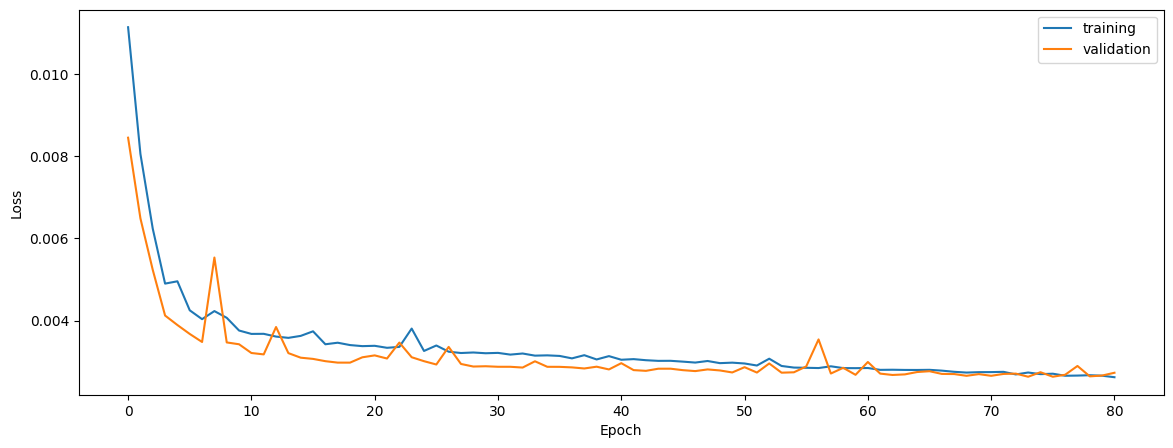

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.8461244584268646
0.8333121090011035
0.8231049607464406


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.8464053861019969
0.849210049596573
0.8294626671385489


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.8444563562327413
0.8456589191665271
0.827609959444779


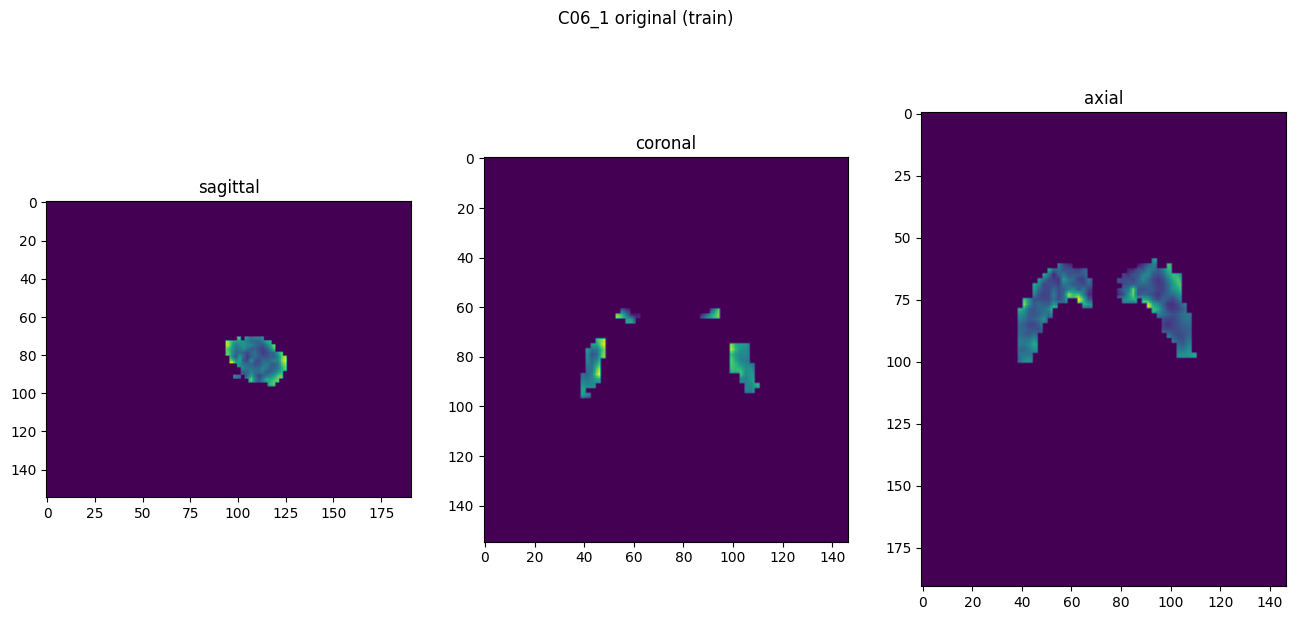

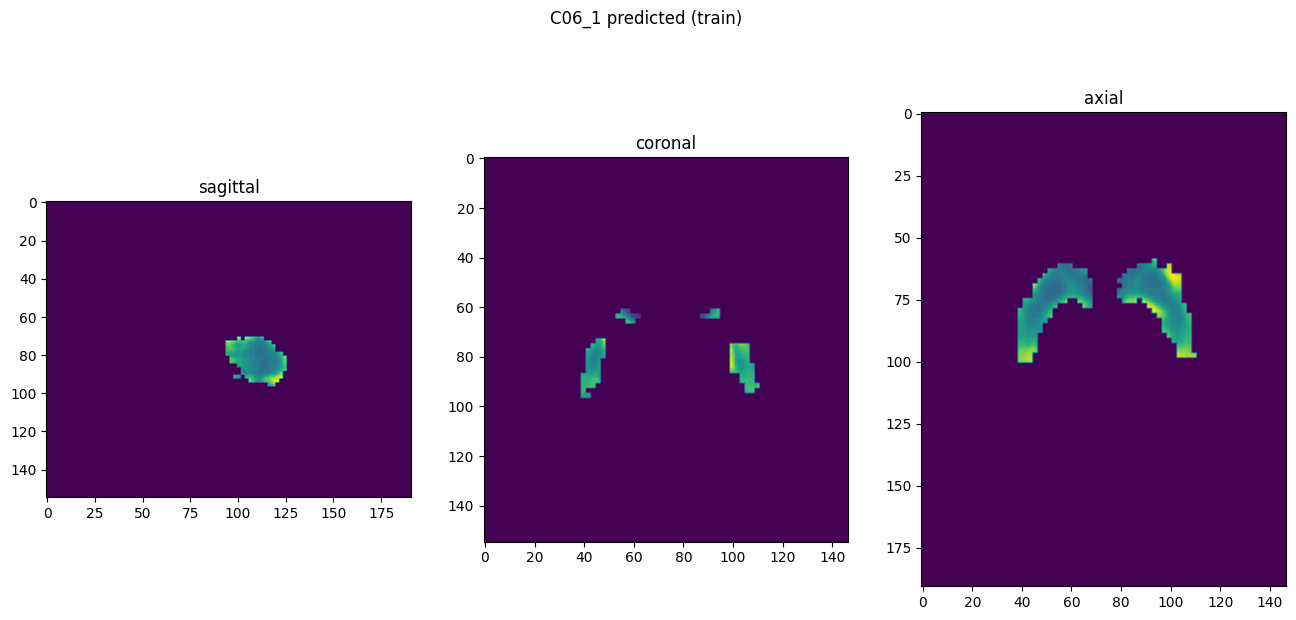

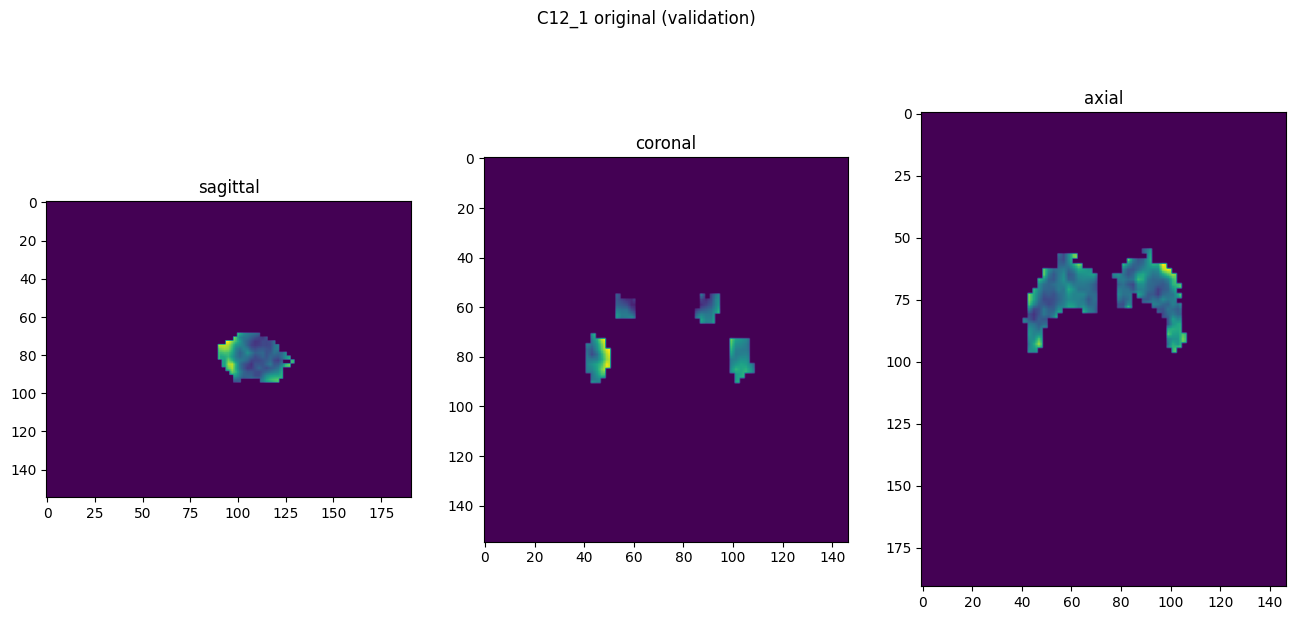

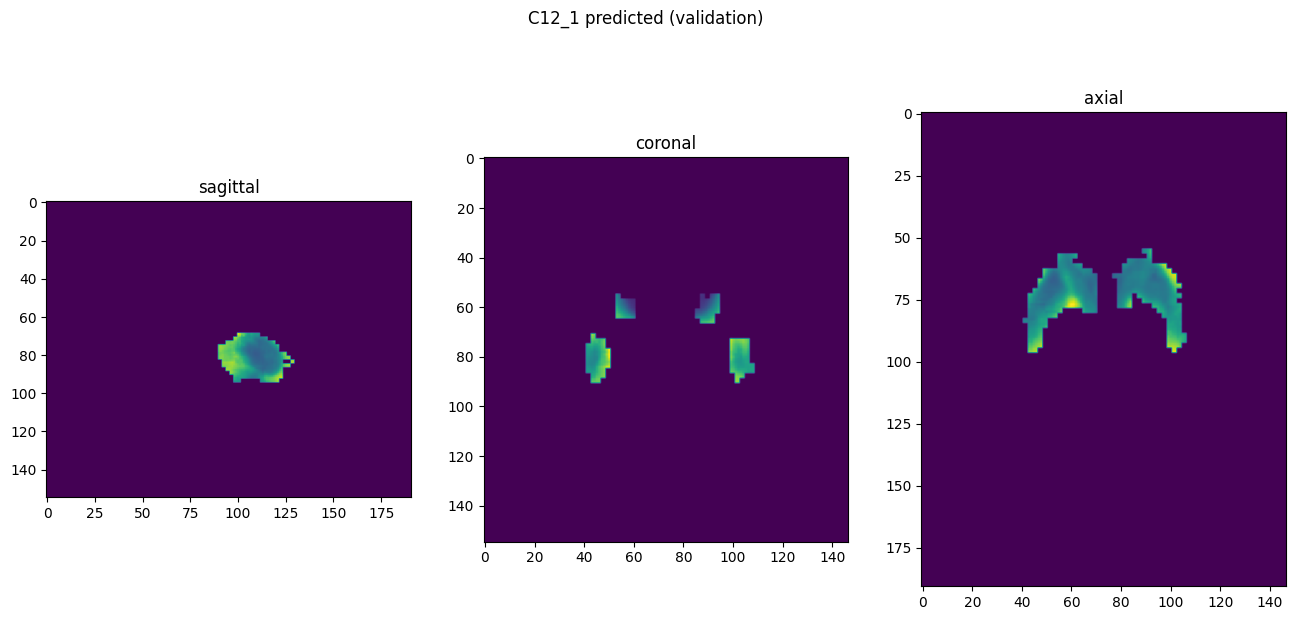

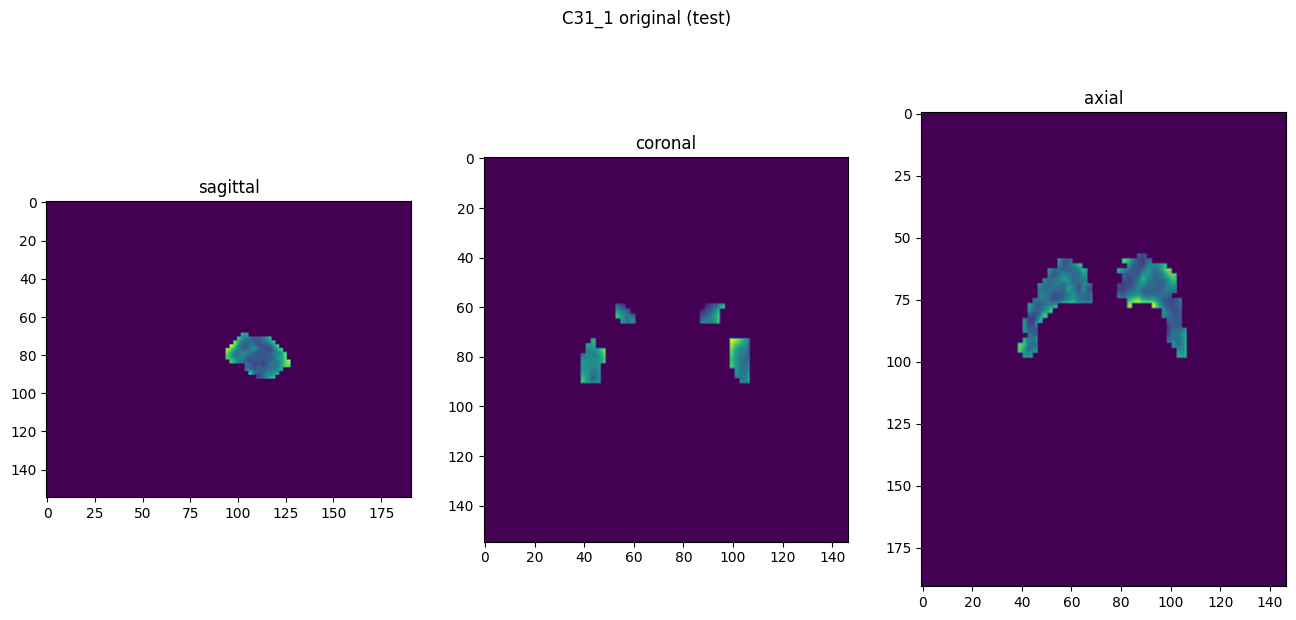

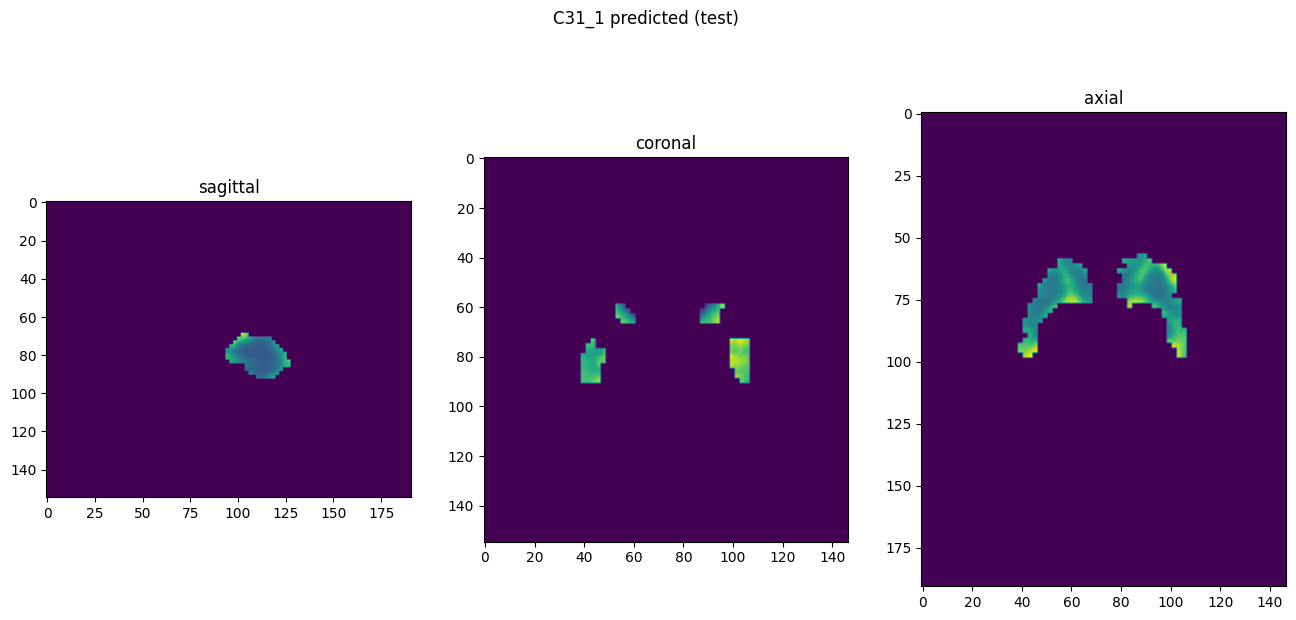

In [10]:
showResults(model, gen, threshold=None, background=False)